In [20]:
import numpy as np
import matplotlib.pyplot as plt
# import time
from matplotlib.image import imread

In [21]:
# from imblearn.under_sampling import RandomUnderSampler
# from collections import Counter

In [22]:
# start = time.time()

In [23]:
seed = 21

In [24]:
np.random.seed(seed)
# torch.manual_seed(seed)

In [25]:
"""
I think this is purely a matter of convention and (most) machine learning researchers and practitioners 
have agreed to adopt the [n_samples, input_size] convention. 
One advantage becomes evident when you one instance is not a vector with d elements, 
but a general [d1, d2, ..., dm] array (e.g. one instance being a [width, height, 3] RGB image). 
With the [n_samples, input_size] convention, you can always rely on the first index being the sample size.
"""


'\nI think this is purely a matter of convention and (most) machine learning researchers and practitioners \nhave agreed to adopt the [n_samples, input_size] convention. \nOne advantage becomes evident when you one instance is not a vector with d elements, \nbut a general [d1, d2, ..., dm] array (e.g. one instance being a [width, height, 3] RGB image). \nWith the [n_samples, input_size] convention, you can always rely on the first index being the sample size.\n'

In [26]:
# train_test_split
train_fraction = 0.9
validation_fraction = 0.0
test_fraction = 0.1

# for training
n_files_to_consider = 1 # total 50

# while training
batch_size = 1
lr = 0.001 # learning_rate

In [27]:
# path = '/content/drive/My Drive/Colab Notebooks/random/prnn_assign1/regression_data_multilinear_group_42_train.txt'
# drive link : https://drive.google.com/file/d/1jSmC64zycUY8akxlRu4DAzNsrNWPoPCX/view?usp=drive_link

# Custom Built Code

In [28]:
def get_minibatch(batch_size = 32, x = None, y = None):
    siz = x.shape[0]
    for j in range(0,siz,batch_size):
        mini_x = x[j:j+batch_size, :] # shape = (n, 25)
        mini_y = y[j:j+batch_size, :] # shape = (n,  1)

        yield mini_x, mini_y

In [29]:
class Linear():
    def __init__(self, ip_nodes = 25, op_nodes = 10, parameters = None, reg = False, power = 2, rp = 1):
        
        self.x = None
        self.z = None
        self.ip_nodes = ip_nodes
        self.op_nodes = op_nodes
        
        # print("parameters : ", type(parameters))
        
        if len(np.array(parameters).shape) == 0: # parameters contains no information
            self.weights = np.random.randn(op_nodes, ip_nodes) # / np.sqrt(self.ip_nodes) #shape = (10, 25)
            self.bias = np.zeros((1, op_nodes)) # shape = (1, 1)
        else:
            self.weights = parameters[0]
            self.bias = parameters[1]
        
        # print(self.weights)
        
        #gradients
        self.dz_by_dw = None
        self.dz_by_db = None
        self.dz_by_dx = self.weights
        
        self.dloss_by_dw = None
        self.dloss_by_db = None
        self.dloss_by_dx = None
    
    def get_parameters(self):
        # print("came here")
        # print([self.weights, self.bias])
        return [self.weights, self.bias]
        
    def forward(self, x, print_data = False): # shape = (n, 25)
        self.x = x
        # print("x.shape : ", x.shape, "self.weights : ", self.weights.shape)
        self.z = x@self.weights.T + self.bias # shape = (n,25)@(10,25).T + n*(1,10)  -> (n, 10)
        return self.z
    

        
    def calculate_grads_wrt_loss(self, dloss_by_dz, print_data=False): #(n, 10)
        
        # print("insise calculate grads wrt loss")
        # print("dloss_by_dz shape : ", dloss_by_dz.shape)
        
        dloss_by_dz = dloss_by_dz[:,np.newaxis,:] #(n,1,10)
        
        self.dloss_by_dx = (dloss_by_dz@self.weights[np.newaxis,:,:])[:,0,:] # (n,1,10)@(1,10,25)->(n,1,25)->(n,25)
        
        self.dloss_by_db = np.average(dloss_by_dz, axis = 0)*self.dz_by_db # (1,10) 
        
        dloss_by_dz = np.repeat(dloss_by_dz[:,np.newaxis,:,:], self.z.shape[-1], axis = 1) # (n,10,1,10)
        
        self.dloss_by_dw = (dloss_by_dz@self.dz_by_dw).squeeze(axis = 2) #(n,10,1,10)@(n,10,10,25)->(n,10,1,25)->(n,10,25)   
        
        self.dloss_by_dw = np.average(self.dloss_by_dw, axis = 0) #(10,25)        
        
        
    def calculate_grads_local(self):
        # self.x shape = (n, 25)
        x_temp = np.copy(self.x)[:, np.newaxis, np.newaxis, :]# shape = (n, 25) -> (n, 1, 1, 25)
        
        r = np.repeat(np.expand_dims(np.eye(self.op_nodes), axis = 2), self.ip_nodes, axis=2) # shape = (10, 10, 25)
        
        f = np.repeat(np.expand_dims(r, axis = 0), self.x.shape[0], axis = 0) # shape = (n, 10, 10, 25)
        
        self.dz_by_dw = f*x_temp # shape = (n,10,10,25)
        
        self.dz_by_db = np.ones((1, self.op_nodes)) # shape = (1, 10)
        self.dz_by_dx = np.repeat(self.weights[np.newaxis,:,:], self.x.shape[0], axis = 0)
        
        
    def calculate_gradients_usual(self, dloss_by_dz): # calculates gradient of the usual part
        self.calculate_grads_local() # 4th dimensional matrix of shape (n, 10, 10, 25)
        self.calculate_grads_wrt_loss(dloss_by_dz)

    
    def backward_and_get_gradients(self, dloss_by_dz, lr = 0.01,reg = False, rp = 0.01,power = 1, print_data=False): #shape  (n, 1, 10)
        
        self.calculate_gradients_usual(dloss_by_dz)
        
        # print("dloss_by_dz.shape : ", dloss_by_dz.shape, "dz_by_dw : ", self.dz_by_dw.shape)        
        
        if reg == True:
            self.weights -= lr*(self.dloss_by_dw)  + rp*np.sum((np.abs(self.weights))**power)# (10,25)
            self.bias -= lr*(self.dloss_by_db) + rp*np.sum((np.abs(self.bias))**power) # shape = (1,10)*(1,10) -> (1,10)
        
        else:
            self.weights -= lr*(self.dloss_by_dw) # (10,25)
            self.bias -= lr*(self.dloss_by_db)# shape = (1,10)*(1,10) -> (1,10)
        

        if print_data:
            print("linear layer")
            print("dloss_by_dw : ", self.dloss_by_dw.shape)
            print("dloss_by_dw : ", self.dloss_by_dw)


            print("dloss_by_db : ", self.dloss_by_db.shape)
            print("dloss_by_db : ", self.dloss_by_db)
            
            print("dloss_by_dx : ", self.dloss_by_dx.shape)
            print("dloss_by_dx : ", self.dloss_by_dx)
            
            
            print("updated weights :", self.weights.shape)
            print("updated weights : : ", self.weights)
            
            print("updated bias : ", self.bias.shape)
            print("updated bias :", self.bias)
            
        # , self.dloss_by_dw, self.dloss_by_db (10,25) (1,10)
        return self.dloss_by_dx # (n,25) 

In [30]:
class Softmax():
    def __init__(self):
        self.z = None
        self.a = None
        
        self.da_by_dz = None
        self.dloss_by_dz = None
     
    def softmax(self, z, print_data=False):  # x.shape  = (n, 10)
        
        if print_data:
            print("z", z.shape)
            print(z)
        
        # if z.shape[0] > 1:
        #     m = np.average(z, axis=0, keepdims = True) # shape = (n, 10)
        # else:
        #     m = np.zeros((1,z.shape[-1]))
        
        m = np.max(z)

        # if print_data:
        #     print("m", m.shape)
        #     print(m)
        
        exponent = np.exp(z-m) # shape = (n, 10)
        
        if  print_data:
            print("exponent", exponent.shape)
            print(exponent)
        
        sum_ = np.sum(exponent, axis = 1, keepdims = True)
        if print_data:
            print("sum_ is 0 in softmax for denominator")
            print(sum_)
        
        op = exponent / sum_  # shape = (n, 10)/(n, 1) -> (n, 10)
        
        if print_data:
            print("op", op.shape)
            print(op)
        
        return  op
        
    def forward(self, z, print_data=False):
        self.z = z # (n, 10)
        self.a = self.softmax(z)
        return self.a # shape = (n, 10)
    
    def backward_and_get_gradients(self, dloss_by_da, lr = 0.01, print_data=False):
        
        """
        example:
        >>> a = np.array([[1,2,3],
                          [4,5,6],
                          [4,5,6],
                          [4,5,6]])
        
        >>> cross_derivatives = np.expand_dims(a, axis = 2)@ np.expand_dims(a, axis = 1)
        >>> cross_derivatives 
                array([[[ 1,  2,  3],
                        [ 2,  4,  6],
                        [ 3,  6,  9]],

                       [[16, 20, 24],
                        [20, 25, 30],
                        [24, 30, 36]],

                       [[16, 20, 24],
                        [20, 25, 30],
                        [24, 30, 36]],

                       [[16, 20, 24],
                        [20, 25, 30],
                        [24, 30, 36]]])
        
        >>> same_derivatives = np.expand_dims(a, axis = 2)*np.eye(a.shape[1])
        >>> same_derivates 
            array([[[1., 0., 0.],
                    [0., 2., 0.],
                    [0., 0., 3.]],

                   [[4., 0., 0.],
                    [0., 5., 0.],
                    [0., 0., 6.]],

                   [[4., 0., 0.],
                    [0., 5., 0.],
                    [0., 0., 6.]],

                   [[4., 0., 0.],
                    [0., 5., 0.],
                    [0., 0., 6.]]])
        
        """
        
        a = self.softmax(self.z, print_data=print_data) # (n, 10)
        
        # same_derivatives = np.expand_dims(a, axis = 2)*np.eye(a.shape[1]) # da1_by_dz1, da2_by_dz2 like that  shape = (n, 10, 10)
        
        # cross_derivatives = np.expand_dims(a, axis = 2)@np.expand_dims(a, axis = 1) # da1_by_dz2, like that terms
        
        # da_by_dz = np.sum(same_derivatives - cross_derivatives, axis = 2) # shape = (n, 10, 10) -> (n, 10)
                               
        # da_by_dz = same_derivatives - cross_derivatives # shape = (n, 10, 10)
        
        
        temp1 = np.repeat(np.expand_dims(-a, axis = 2), a.shape[1], axis = 2) \
              + np.repeat(np.expand_dims(np.eye(a.shape[1]), axis = 0), a.shape[0], axis = 0)
        
        if print_data:
            print("inside softmax")
        
        
        # print("temp 1", temp1.shape)
        
        self.da_by_dz = a[:,:,np.newaxis]*temp1
        
        
        # da_by_dz = da_by_dz.transpose(0,2,1)
        
        # print("da_by_dz", self.da_by_dz.shape)
        
        dloss_by_da = dloss_by_da[:,np.newaxis,:] # (n,10) -> (n,1,10)
        
        if print_data :
            # print("dloss_by_dx : ", dloss_by_dx.shape)
            # print("dloss_by_dx : ", dloss_by_dx)
            
            print("dloss_by_da : ", dloss_by_da.shape)
            print("dloss_by_da : ", dloss_by_da)
            
            
            print("da_by_dz : ", self.da_by_dz.shape)
            print("da_by_dz : ", self.da_by_dz)
        
        
        self.dloss_by_dz = (dloss_by_da@self.da_by_dz)[:,0,:] # (n,1,10)@(n,10,10) -> (n,1,10) -> (n, 10)
        
        if print_data :

            # print("dloss_by_dx : ", dloss_by_dx.shape)
            # print("dloss_by_dx : ", dloss_by_dx)
            
            print("self.dloss_by_dz : ", self.dloss_by_dz.shape)
            print("self.dloss_by_dz : ", self.dloss_by_dz)
        
        
        # self.dloss_by_dz = np.repeat(self.dloss_by_dz[:,np.newaxis,:,:], self.z.shape[-1], axis = 1) # (n,10,1,10)
        
        
        
        return self.dloss_by_dz # shape = (n,10)

In [31]:
class Sigmoid():
    def __init__(self):
        self.z = None
        self.a = None
        
        self.da_by_dz = None # local loss
        self.dloss_by_dz = None # global loss
        
        
    def sigmoid(self, z, print_data=False):
        self.z = z #shape = (n,k) k is number of nodes
        
        self.a = np.sigmoid(z) # (n,k)
        
    
    def forward(self, z, print_data=False):
        self.sigmoid(z)
        return self.a # shape = (n,k)
        
         
    def backward_and_get_gradients(self, dloss_by_da, lr = 0.01, print_data=False): # shape of dloss_by_da = (n, k)
        
        if print_data:
            print("inside sigmoid")
        
        # dloss_by_da = dloss_by_da[:,np.newaxis,:] # (n,k) -> (n, 1, k)
        
        # lengthy method
        # a_temp = self.a[:,:,np.newaxis]
        # da_by_dz = a_temp*np.repeat(np.eye(self.z.shape[-1])[np.newaxis,:,:], self.z.shape[0], axis = 0) # (n,k,1)*(n,k,k) -> (n,k,k)
        # self.da_by_dz = np.array(da_by_dz >= 0, dtype = int)
        # self.dloss_by_dz = (dloss_by_da@self.da_by_dz)[:,0,:] # final shape  = (n,1,k) -> (n,k)
        
        
        # shortcut
        self.da_by_dz = self.a*(1-self.a) # shape = (n,k)
        
        self.dloss_by_dz = self.da_by_dz * self.dloss_by_da # (n,k)*(n,k) -> (n,k)
        
        
        
        return self.dloss_by_dz  # (n,k)

In [32]:
class ReLU():
    def __init__(self):
        self.z = None
        self.a = None
        
        self.da_by_dz = None # local loss
        self.dloss_by_dz = None # global loss
        
        
    def relu(self, z, print_data=False):
        self.z = z #shape = (n,k) k is number of nodes
        self.a = np.maximum(z,0) # (n,k)
        
    
    def forward(self, z, print_data=False):
        self.relu(z)
        return self.a # shape = (n,k)
        
         
    def backward_and_get_gradients(self, dloss_by_da, lr = 0.01, print_data=False): # shape of dloss_by_da = (n, k)
        
        if print_data:
            print("inside relu")
        
        # dloss_by_da = dloss_by_da[:,np.newaxis,:] # (n,k) -> (n, 1, k)
        
        # lengthy method
        # a_temp = self.a[:,:,np.newaxis]
        # da_by_dz = a_temp*np.repeat(np.eye(self.z.shape[-1])[np.newaxis,:,:], self.z.shape[0], axis = 0) # (n,k,1)*(n,k,k) -> (n,k,k)
        # self.da_by_dz = np.array(da_by_dz >= 0, dtype = int)
        # self.dloss_by_dz = (dloss_by_da@self.da_by_dz)[:,0,:] # final shape  = (n,1,k) -> (n,k)
        
        
        # shortcut
        self.da_by_dz = np.array(self.a >= 0, dtype = int) # shape = (n,k)
        
        self.dloss_by_dz = self.da_by_dz * dloss_by_da # (n,k)*(n,k) -> (n,k)
        
        
        
        return self.dloss_by_dz  # (n,k)

In [33]:
class Matured_Layer():
    def __init__(self, activation = 'relu', ip_nodes = 25, op_nodes = 10, parameters = None, reg = False, power = 2, rp = 1):
        self.x = None
        
        self.a = None
        
        self.activation_type = activation
        self.linear = Linear(ip_nodes = ip_nodes, op_nodes = op_nodes, parameters = parameters, reg = reg,power = power,rp = rp)
        
        
        if activation == 'relu':
            self.activation = ReLU()
        elif activation == 'sigmoid':
            self.activation = Sigmoid()
        elif activation == 'softmax':
            self.activation = Softmax()
        elif activation == 'linear':
            self.activation = None
    
    def forward(self, x, print_data = False):
        self.x = x
        if self.activation_type == 'linear':
            self.a = self.linear.forward(self.x)
            if print_data:
                print("forward pass after linear layer:", self.a)
        else:
            temp = self.linear.forward(self.x)
            self.a = self.activation.forward(temp)
            if print_data:
                print("forward pass after linear layer:", temp)
                print("forward pass after activation layer:", self.a) 
        return self.a
    
    def backward_and_get_gradients(self, dloss_by_da, lr = 0.01, print_data=False):
        if self.activation_type == 'linear':
            dloss_by_dx = self.linear.backward_and_get_gradients(dloss_by_da, lr = lr, print_data=print_data)
        else:
            dloss_by_dx = self.linear.backward_and_get_gradients(
                                self.activation.backward_and_get_gradients(dloss_by_da, lr = lr, \
                                                                           print_data=print_data),\
                                lr = lr,\
                                print_data=print_data)
        return dloss_by_dx

In [34]:
class Model():
    def __init__(self, ip_nodes = 25, hidden_nodes = [], op_nodes = 10,\
                 intermediate_activations = 'relu', final_activation = 'softmax',\
                 parameters = None, reg = False, power = 2, rp = 1):
        self.x = None
        self.a = None
        self.n_nodes = [ip_nodes] + hidden_nodes + [op_nodes]
        
        self.layers = []
        self.final_activation = final_activation
        
        if parameters is None:
            parameters = [None] * len(self.n_nodes)
        
        # print(index, i, j)
        #print(parameters)
        #print(self.n_nodes)
        for index,tup in enumerate(zip(self.n_nodes[:-2],self.n_nodes[1:-1])):
            i = tup[0]
            j = tup[1]
            #print(index, i, j)
            self.layers.append(Matured_Layer(ip_nodes = i, op_nodes = j, \
                                              activation = 'relu', \
                                             parameters = parameters[index],\
                                             reg = reg, power = power, rp = rp))
            
        self.layers += [Matured_Layer(ip_nodes = self.n_nodes[-2], op_nodes = self.n_nodes[-1],\
                                      activation = final_activation, parameters = parameters[-1])]
        self.final_parameters = parameters
        
        
    def get_parameters(self):
        # saving
        # temp_weights = model.layer1.weights
        # temp_bias = model.layer1.bias

        # with open('weights.pkl', 'wb') as f:
        #     pkl.dump(temp_weights, f)

        # with open('bias.pkl', 'wb') as f:
        #     pkl.dump(temp_bias, f)
        
        # reading
        # try:
        #     with open('weights.pkl', 'rb') as f:
        #         self.weights = pkl.load(f)

        #     with open('bias.pkl', 'rb') as f:
        #         self.bias = pkl.load(f)

        # except:
        #     self.weights = np.random.randn(op_nodes, ip_nodes) #shape = (10, 25)
        #     self.bias = np.zeros((1, op_nodes)) # shape = (1, 10)
        
        # b = np.load('a.npy', allow_pickle=True)
        
        return self.final_parameters
        
    
    def forward(self, x, print_data = False): # shape = (n, 25)
        self.x = x # shape = (n, 25)
        
        self.a = self.x
        for layer in self.layers:
            self.a = layer.forward(self.a, print_data = print_data)
            if print_data:
                print("forward pass after matured layer:", self.a)
        
        return self.a
        
    
    def round_the_ops(self,a): # shape = (n, 10)
            """
            task: makes the max element 1 and rest 0
            
            """
            maxes = np.max(a, axis = 1, keepdims = True) # (n ,10) -> (n, 1)
            return np.array(a==maxes, dtype = int) # shape = (n, 10)
    
    def fit(self, generator = get_minibatch, x = None, y = None, \
            n_epochs = 1, lr = 0.01, batch_size = 32, print_data=False, reg = False, power = 2, rp = 1,\
           end_after_first_iteration = False): # train_x shape  = (n, 25) , (n, 10)
        
        self.final_parameters = []
        
        def confusion_matrix(y, y_hats):
            """
            Confusion matrix whose i-th row and j-th column entry indicates the 
            number of samples with true label being i-th class and predicted 
            label being j-th class.
            """
            #y = y.copy().squeeze().astype(int)
            #y_hats = y_hats.copy().squeeze().astype(int)

            n_classes = y.shape[1]
            cm = np.zeros((n_classes,n_classes))

            # tuples = np.array(tuple(zip(y,y_hats)))
            for i in range(y.shape[0]):
                cm[np.argmax(y[i]), np.argmax(y_hats[i])] += 1

            return cm


        def ohe(y): # one hot encoding, shape of y = (n,1) # each  element represents a class 
            """
            example:
            >>> r = np.random.randint(0,10,(4,1))
            >>> r
                array([[7],
                       [2],
                       [1],
                       [0]])
            >>> t= np.eye(10)[r]
            >>> t.shape
                (4, 1, 10)
            >>> t1 = t[:,0,:]
            >>> t1.shape
            array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                   [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
                   [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                   [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]])
            
            random_syntax [repeated 'eyes'] :
            >>> np.array([np.eye(2)]*4)
                array([[[1., 0.],
                        [0., 1.]],

                       [[1., 0.],
                        [0., 1.]],

                       [[1., 0.],
                        [0., 1.]],

                       [[1., 0.],
                        [0., 1.]]])
            """
            
            return np.eye(self.n_nodes[-1])[y][:,0,:]
        

        
        def get_loss(a, y): # shapes a = (n, 10), y = (n, 10) # 10 output nodes
            
            if self.final_activation == "softmax": # cross entropy loss
                loss = np.average(-1*np.sum(y*np.log(a), axis = 1)) #scalar
            elif self.final_activation == 'linear': # mean squared error loss
                loss = np.average((a-y)*(a-y), axis = 0, keepdims = True) # row vector shape  = (1, k) # k op nodes
                
            if print_data:
                print("loss : ",loss.shape, loss)
            
            return loss  
        
        
        def get_dloss_by_da(a, y): # shape of a & y = (n, 10)
            if self.final_activation == 'softmax':
                dloss_by_da = -y/a # shape = (n, 10)/(n, 10) -> (n, 10)
            elif self.final_activation == 'linear':
                dloss_by_da = 2*(a-y) # shape = (n, 10)
            return dloss_by_da  # shape = (n, 10)
        
        training_accuracies = []
        training_losses = []
        lr_backup = lr
        for i in range(n_epochs):
            lr = lr_backup
            for iter_num, data in enumerate(generator(x = x, y = y, batch_size = batch_size)):
                
                try:
                    if training_losses[-1] > training_losses[-2]:
                        lr = lr/10
                except:...
                
                mini_x = data[0] # shape = (n, 25)
                if self.final_activation == 'softmax':
                    mini_y = ohe(data[1].astype(int)) # shape = (n, 10)
                elif self.final_activation == 'linear':
                    mini_y = data[1]
                
                if print_data :
                    print(iter_num,"\n\n\n")
                    print("mini_x", mini_x, "mini_y", mini_y)

                # forward pass
                a = self.forward(mini_x, print_data = print_data)
                
                
                if self.final_activation == 'softmax':
                    y_hat = self.round_the_ops(a) # shape = (n, 10) -> (n, 10)
                elif self.final_activation == 'linear':
                    y_hat = a
                
                
                loss = get_loss(a, mini_y)
                
                if print_data:
                    print("y_hat : ", y_hat, "loss : ", loss, "mini_y : ", mini_y)
                
                
                # calculate the gradients
                
                dloss_by_da = get_dloss_by_da(a, mini_y) # shape = (n, 1, 10)
                
                if print_data :
                    print("dloss_by_da : ", dloss_by_da.shape)
                    print("dloss_by_da : ", dloss_by_da)
                
                #update weights
                
                temp_grad = dloss_by_da
                for layer in reversed(self.layers):
                    temp_grad = layer.backward_and_get_gradients(temp_grad, lr = lr, print_data=print_data)
                    
                    if print_data :
                        print("temp_grad : ", temp_grad.shape)
                        print("temp_grad : ", temp_grad)
                    
                # book keeping
                training_losses.append(loss)
                
                #print(mini_x.shape, mini_y.shape)
                #print(y_hat)
                #print(mini_y)
                if self.final_activation == 'softmax':
                    cm = confusion_matrix(y_hat, mini_y)
                    tr = np.trace(cm)
                    cnt = np.sum(cm)
                    training_accuracies.append((tr/cnt)*100)
                
                
                if end_after_first_iteration:
                    break
                
                if np.isnan(loss.any()):
                    break
                    
            if np.isnan(loss.any()):
                    break
                    
            if end_after_first_iteration:
                break
        for matured_layer in self.layers:
            #print("came here 2")
            #print(matured_layer.linear.get_parameters())
            self.final_parameters.append(matured_layer.linear.get_parameters())
        
        self.final_parameters = np.array(self.final_parameters, dtype = object)
        
        return training_losses, training_accuracies
        

## Miscellaneous functions

In [35]:
def get_mse_loss(y, y_hats):
    return np.average(np.square((y - y_hats)), axis = 0, keepdims = False)

def get_mae_loss(y, y_hats):
    loss = np.average(np.abs(y - y_hats), axis = 0, keepdims = False) # shape = (n,3) -> (1,3)
    return loss

In [36]:
def confusion_matrix(y, y_hats):
    """
    Confusion matrix whose i-th row and j-th column entry indicates the 
    number of samples with true label being i-th class and predicted 
    label being j-th class.
    """
    y = y.copy().squeeze().astype(int)
    y_hats = y_hats.copy().squeeze().astype(int)
    
    n_classes = np.unique(y).shape[0]
    cm = np.zeros((n_classes,n_classes))
    
    # tuples = np.array(tuple(zip(y,y_hats)))
    for i in range(y.shape[0]):
        cm[y[i], y_hats[i]] += 1
    
    return cm

# 0. Binary Class Classification

## 0.1. Read Data

In [22]:
path_b = "binary_classification/binary_classification_data_group_42_train.txt"

In [23]:
# np.loadtxt(path_b, delimiter='\t', skiprows=1)

In [24]:
# file_path = '/content/drive/My Drive/prnn_q5.txt'
df_b = np.loadtxt(path_b, delimiter='\t', skiprows=1) # shape = (n, 26)

print(df_b.shape)
mins_b = np.min(df_b[:,:-1], axis = 0, keepdims = True)
maxs_b = np.max(df_b[:,:-1], axis = 0, keepdims = True)

# Normalisation
df_b[:,:-1] = (df_b[:,:-1] - mins_b)/(maxs_b - mins_b)


(14000, 11)


In [25]:
np.random.shuffle(df_b)

In [26]:
train_last_index_b = int(df_b.shape[0]*train_fraction)
validation_last_index_b = int(df_b.shape[0]*(train_fraction+validation_fraction))


train_df_b = df_b[:train_last_index_b, :]
train_x_b = train_df_b[:, :-1] # shape = (n, 25)
train_y_b = train_df_b[:, -1:] # shape = (n, 10)

validation_df_b = df_b[:validation_last_index_b, :]

test_df_b = df_b[validation_last_index_b:, :]
test_x_b = test_df_b[:, :-1] # shape = (n, 10)
test_y_b = test_df_b[:, -1:] # shape = (n,  3)

In [27]:
print(df_b.shape, train_df_b.shape, validation_df_b.shape, test_df_b.shape)

(14000, 11) (12600, 11) (12600, 11) (1400, 11)


In [28]:
print(train_x_b.shape, train_y_b.shape, test_x_b.shape, test_y_b.shape)

(12600, 10) (12600, 1) (1400, 10) (1400, 1)


In [29]:
train_y_b

array([[0.],
       [1.],
       [0.],
       ...,
       [0.],
       [1.],
       [1.]])

## 0.2 Coding

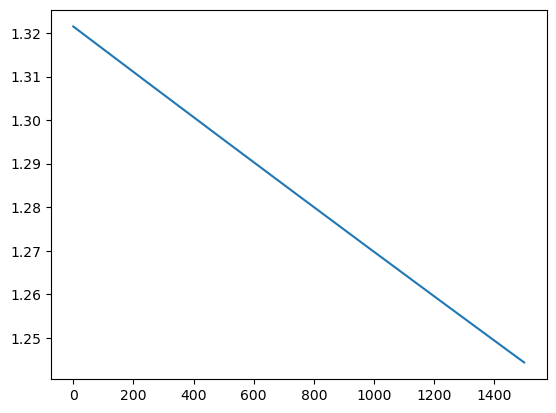

In [30]:
parameters_b = None # np.load('parameters_binary_lr.npy', allow_pickle=True)
#print(parameters[0][0][0][0])
model_b = Model(ip_nodes = 10, hidden_nodes = [], op_nodes = 2,\
              intermediate_activations = 'sigmoid',final_activation = 'softmax', parameters = parameters_b)


batch_size_b = 2**14
lr_b = 5e-3
n_epochs_b = 1500
print_data_b = False

# print(train_x.shape, train_y.shape)
losses_b, accs_b = model_b.fit(generator = get_minibatch, x = train_x_b, y = train_y_b, lr = lr_b, \
                   n_epochs = n_epochs_b, batch_size = batch_size_b, print_data = print_data_b)

model_params_b = model_b.get_parameters()
#print(model_params[0][0][0][0])
# np.save('parameters.npy', model_params)

losses_b = np.array(losses_b).squeeze()
plt.plot(losses_b)

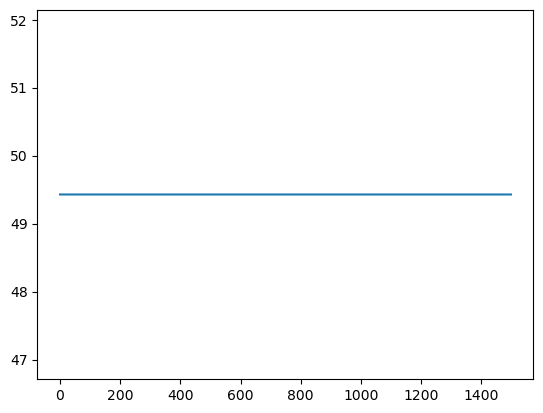

In [31]:
plt.plot(accs_b)
#plt.ylim((49.99,50.01))

In [32]:
# np.save('parameters_binary_lr.npy', model_params_b)

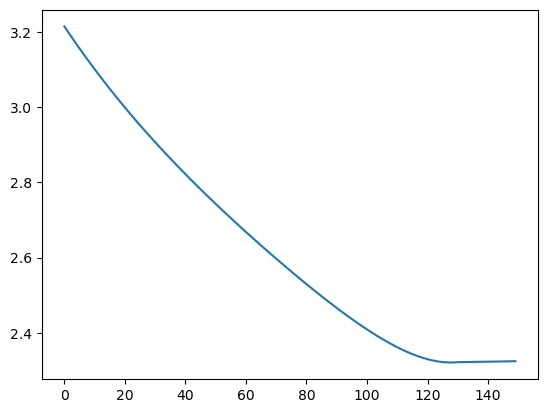

In [33]:
parameters_b = np.load('parameters_b.npy', allow_pickle=True)
#print(parameters[0][0][0][0])
model_b = Model(ip_nodes = 10, hidden_nodes = [10,7], op_nodes = 2,\
              intermediate_activations = 'sigmoid',final_activation = 'softmax', parameters = parameters_b)


batch_size_b = 2**14
lr_b = 5e-2
n_epochs_b = 150
print_data_b = False

# print(train_x.shape, train_y.shape)
losses_b, accs_b = model_b.fit(generator = get_minibatch, x = train_x_b, y = train_y_b, lr = lr_b, \
                   n_epochs = n_epochs_b, batch_size = batch_size_b, print_data = print_data_b)

model_params_b = model_b.get_parameters()
#print(model_params[0][0][0][0])
# np.save('parameters.npy', model_params)

losses_b = np.array(losses_b).squeeze()
plt.plot(losses_b)

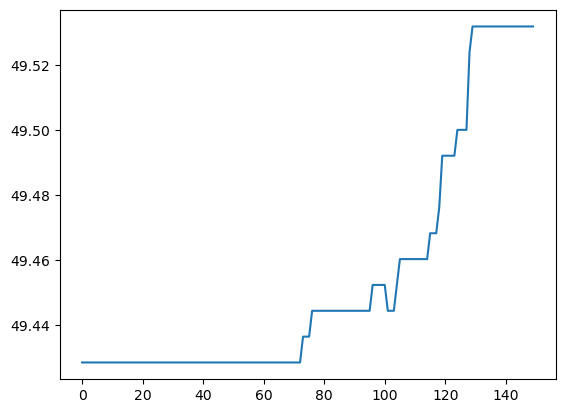

In [34]:
plt.plot(accs_b)
#plt.ylim((49.99,50.01))

In [35]:
losses_b[::50]

array([3.2145056 , 2.74257971, 2.40875101])

### 0.3. Custom Code - Testing

In [36]:
test_y_b = test_y_b.squeeze()
print(test_x_b.shape, test_y_b.shape)

(1400, 10) (1400,)


In [37]:
# production
a_b = model_b.forward(test_x_b)

In [38]:
# model.round_the_ops(model.activation1.softmax(model.layer1.z)), axis = 1
y_hats_b = np.argmax(model_b.forward(test_x_b), axis =1).squeeze()
print(y_hats_b.shape, y_hats_b)

(1400,) [1 1 1 ... 1 1 1]


In [39]:
test_y_b

array([1., 1., 1., ..., 0., 1., 1.])

In [40]:
y_hats_b

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [41]:
cm_b = confusion_matrix(test_y_b, y_hats_b)
cm_b

array([[  2., 697.],
       [  1., 700.]])

In [42]:
# count per class
true_counts_per_class_b = np.sum(cm_b, axis = 0)
print("true_counts_per_class : ", true_counts_per_class_b)

tr_b = np.trace(cm_b)
print("trace : ", tr_b)

tot_b = np.sum(cm_b)
print("tot : ", tot_b)


accuracy_b = tr_b/tot_b
print("accuracy :", accuracy_b)

true_counts_per_class :  [   3. 1397.]
trace :  702.0
tot :  1400.0
accuracy : 0.5014285714285714


# 1. Multi Class Classification task

## 1.1. Read Data

In [43]:
# def undersample(df, idx):
#     # under sampling

#     rus = RandomUnderSampler(random_state=seed)
#     X_resampled, y_resampled = rus.fit_resample(df[:,:-idx],df[:, -idx:])
#     print(sorted(Counter(y_resampled).items()))
    
#     print(X_resampled.shape, y_resampled.shape)
    
#     return np.concatenate([X_resampled, y_resampled[:,np.newaxis]], axis= 1)

In [44]:
path_m = 'multi_class_classification/multi_class_classification_data_group_8_train.txt'

In [45]:
np.loadtxt(path_m, delimiter='\t', skiprows=1)

array([[ 0.8853503 ,  0.00925915,  0.18175457, ...,  0.89467568,
         2.60055104,  8.        ],
       [-1.27466697,  0.27793558, -0.09589076, ...,  1.30238023,
         0.32576481,  5.        ],
       [ 2.16281675,  0.98764051,  0.74229805, ...,  1.38010054,
         0.47406783,  7.        ],
       ...,
       [ 0.54912062, -0.24489376, -0.53892179, ...,  1.6153558 ,
         0.52678551,  9.        ],
       [-0.01215941,  2.12670395,  0.31546656, ...,  1.06813359,
        -0.31738335,  9.        ],
       [ 1.73206556, -0.60162639,  0.02754036, ...,  0.20809199,
         0.41531458,  5.        ]])

In [46]:
# file_path = '/content/drive/My Drive/prnn_q5.txt'
df_m = np.loadtxt(path_m, delimiter='\t', skiprows=1) # shape = (n, 26)

print(df_m.shape)
mins_m = np.min(df_m[:,:-1], axis = 0, keepdims = True)
maxs_m = np.max(df_m[:,:-1], axis = 0, keepdims = True)

# Normalisation
df_m[:,:-1] = (df_m[:,:-1] - mins_m)/(maxs_m - mins_m)


(70000, 26)


In [47]:
# df = undersample(df, 1)

In [48]:
np.random.shuffle(df_m)

In [49]:
train_last_index_m = int(df_m.shape[0]*train_fraction)
validation_last_index_m= int(df_m.shape[0]*(train_fraction+validation_fraction))


train_df_m = df_m[:train_last_index_m, :]
train_x_m = train_df_m[:, :-1] # shape = (n, 25)
train_y_m = train_df_m[:, -1:] # shape = (n, 10)

validation_df_m = df_m[:validation_last_index_m, :]

test_df_m = df_m[validation_last_index_m:, :]
test_x_m = test_df_m[:, :-1] # shape = (n, 10)
test_y_m = test_df_m[:, -1:] # shape = (n,  3)

In [50]:
print(df_m.shape, train_df_m.shape, validation_df_m.shape, test_df_m.shape)

(70000, 26) (63000, 26) (63000, 26) (7000, 26)


## 1.2. Start Coding

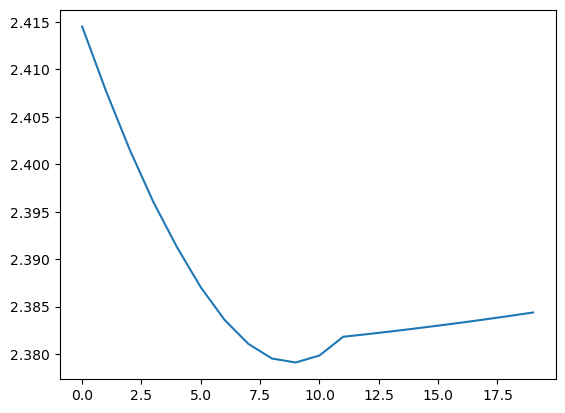

In [51]:
parameters_m = np.load('parameters_m.npy', allow_pickle=True)
#print(parameters[0][0][0][0])
model_m = Model(ip_nodes = 25, hidden_nodes = [7,7,7], op_nodes = 10,\
              intermediate_activations = 'sigmoid',final_activation = 'softmax', parameters = parameters_m)


batch_size_m = 2**16
lr_m = 5e-2
n_epochs_m = 20
print_data_m = False

# print(train_x.shape, train_y.shape)
losses_m, accs_m = model_m.fit(generator = get_minibatch, x = train_x_m, y = train_y_m, lr = lr_m, \
                   n_epochs = n_epochs_m, batch_size = batch_size_m, print_data = print_data_m)

model_params_m = model_m.get_parameters()
#print(model_params[0][0][0][0])
# np.save('parameters.npy', model_params)

losses_m = np.array(losses_m).squeeze()
plt.plot(losses_m)

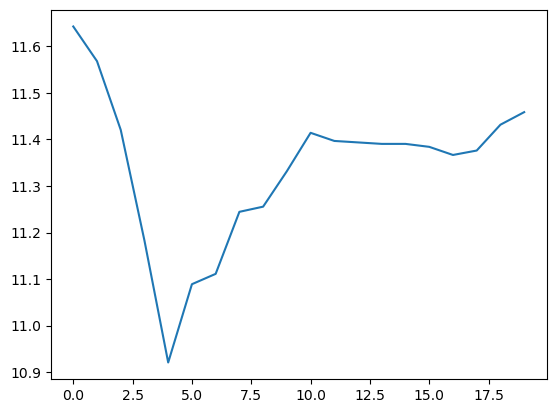

In [52]:
plt.plot(accs_m)

In [53]:
# np.save('parameters_m.npy', model_params_m)

In [54]:
losses_m[::4]

array([2.41453272, 2.39125077, 2.37952941, 2.38209675, 2.3833224 ])

### 1.3. Custom Code - Testing

In [55]:
test_y_m = test_y_m.squeeze()
print(test_x_m.shape, test_y_m.shape)

(7000, 25) (7000,)


In [56]:
# production
a_m = model_m.forward(test_x_m)

In [57]:
# model.round_the_ops(model.activation1.softmax(model.layer1.z)), axis = 1
y_hats_m = np.argmax(model_m.forward(test_x_m), axis =1).squeeze()
print(y_hats_m.shape, y_hats_m)

(7000,) [6 3 6 ... 6 6 4]


In [58]:
cm_m = confusion_matrix(test_y_m, y_hats_m)
cm_m

array([[  0.,   3.,   0., 113., 259.,  77., 134., 121.,   0.,   0.],
       [  0.,   8.,   0.,  82., 250.,  85., 159., 104.,   2.,   0.],
       [  0.,   5.,   0.,  89., 277.,  76., 157.,  63.,   2.,   0.],
       [  0.,   5.,   0., 114., 262., 107.,  92., 134.,   0.,   0.],
       [  0.,   7.,   0.,  73., 372.,  61., 132.,  66.,   0.,   0.],
       [  0.,   6.,   0., 107., 263., 112., 100., 158.,   1.,   0.],
       [  0.,   3.,   0.,  73., 299.,  74., 141.,  69.,   2.,   0.],
       [  0.,   5.,   0.,  81., 233., 121., 176.,  86.,   1.,   0.],
       [  0.,   0.,   0.,  78., 298.,  86., 142.,  94.,   1.,   0.],
       [  0.,   6.,   0.,  76., 229., 105., 160., 123.,   0.,   0.]])

In [59]:
# count per class
true_counts_per_class_m = np.sum(cm_m, axis = 0)
print("true_counts_per_class : ", true_counts_per_class_m)

tr_m = np.trace(cm_m)
print("trace : ", tr_m)

tot_m = np.sum(cm_m)
print("tot : ", tot_m)


accuracy_m = tr_m/tot_m
print("accuracy :", accuracy_m)

true_counts_per_class :  [   0.   48.    0.  886. 2742.  904. 1393. 1018.    9.    0.]
trace :  834.0
tot :  7000.0
accuracy : 0.11914285714285715


## 1.6. Production

In [66]:
x_m = test_x_m[0,:]
y_m = np.argmax(model_m.forward(x_m))
print("given x :", x_m)
print("predicted class :", y_m)

given x : [0.41606402 0.61149414 0.4502237  0.50253811 0.48778163 0.6119066
 0.3122303  0.6348234  0.37790816 0.49807679 0.54936138 0.55842675
 0.51297465 0.53466983 0.62651961 0.438981   0.27664078 0.595468
 0.62786515 0.58176633 0.44797843 0.42544661 0.57920101 0.51562321
 0.59609927]
predicted class : 6


# 2. Linear Regression Task

Multilinear Regression - You need to find the position of a particle in 3D space (y1, y2,
and y3) given a 10-dimensional feature vector. The features are readings from 10 sensors in
the experiment environment. It is experimentally seen that the position of the particle depends
linearly on these readings. Can you figure out the relationship?

## 2.1. Read Data

In [67]:
path_lr = 'Regression_Linear_multi/regression_data_multilinear_group_42_train.txt'

In [68]:
np.loadtxt(path_lr, delimiter='\t', skiprows=1)

array([[-1.38969116e+00,  1.93124152e+00, -2.68382926e+00, ...,
        -1.13100795e+01, -4.67358138e+00, -2.20981726e+01],
       [-1.53005253e-01,  2.34106073e-02, -3.58194589e-03, ...,
         2.30782695e+00,  5.21017603e+00, -4.19624131e+00],
       [ 1.35845640e+00,  1.84540378e+00,  2.50690057e+00, ...,
        -2.67788333e-01, -4.10540905e+00, -9.78360577e+00],
       ...,
       [ 1.26243024e+00,  1.59373010e+00,  2.01197307e+00, ...,
         5.60525899e+00, -6.03377518e-01, -6.88396508e+00],
       [-1.05252240e+00,  1.10780341e+00, -1.16598791e+00, ...,
        -4.19253655e+00,  5.33004249e-01, -1.01881438e+01],
       [-1.42905366e+00,  2.04219436e+00, -2.91840532e+00, ...,
        -1.59750217e+00, -1.26874660e+00, -9.54663932e+00]])

In [69]:
# file_path = '/content/drive/My Drive/prnn_q5.txt'
df_lr = np.loadtxt(path_lr, delimiter='\t', skiprows=1) # shape = (n, 26)

print(df_lr.shape)
mins_lr = np.min(df_lr[:,:], axis = 0, keepdims = True)
maxs_lr = np.max(df_lr[:,:], axis = 0, keepdims = True)

# Normalisation
df_lr[:,:] = (df_lr[:,:] - mins_lr)/(maxs_lr - mins_lr)


(14000, 13)


In [70]:
# df = undersample(df,  3)

In [71]:
df_lr.shape

(14000, 13)

In [72]:
np.random.shuffle(df_lr)

In [73]:
train_last_index_lr = int(df_lr.shape[0]*train_fraction)
validation_last_index_lr = int(df_lr.shape[0]*(train_fraction+validation_fraction))


train_df_lr = df_lr[:train_last_index_lr, :]
train_x_lr = train_df_lr[:, :-3] # shape = (n, 25)
train_y_lr = train_df_lr[:, -3:] # shape = (n, 10)

validation_df_lr = df_lr[:validation_last_index_lr, :]

test_df_lr = df_lr[validation_last_index_lr:, :]
test_x_lr = test_df_lr[:, :-3] # shape = (n, 10)
test_y_lr = test_df_lr[:, -3:] # shape = (n,  3)

In [74]:
print(df_lr.shape, train_df_lr.shape, validation_df_lr.shape, test_df_lr.shape)

(14000, 13) (12600, 13) (12600, 13) (1400, 13)


## 2.2. Start coding

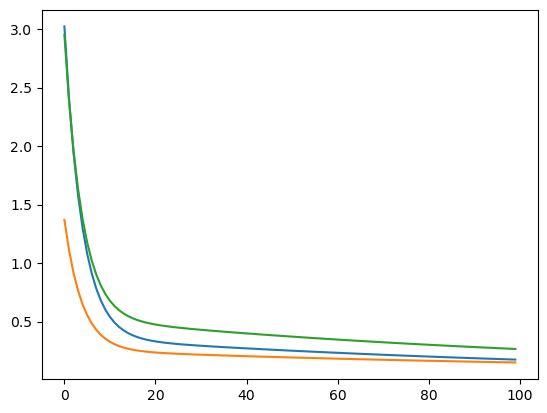

In [75]:
parameters_lr = None #np.load('parameters_regression.npy', allow_pickle=True)
#print(parameters[0][0][0][0])
model_lr = Model(ip_nodes = 10, hidden_nodes = [], op_nodes = 3, \
              intermediate_activations = 'sigmoid', final_activation = 'linear', parameters = parameters_lr)


batch_size_lr = 2**14
lr_lr = 2e-2
n_epochs_lr = 100
print_data_lr = False

# print(train_x.shape, train_y.shape)
losses_lr,_ = model_lr.fit(generator = get_minibatch, x = train_x_lr, y = train_y_lr, lr = lr_lr, \
                   n_epochs = n_epochs_lr, batch_size = batch_size_lr, print_data = print_data_lr)

model_params_lr = model_lr.get_parameters()
#print(model_params[0][0][0][0])
# np.save('parameters.npy', model_params_regression)

losses_lr = np.array(losses_lr).squeeze()
plt.plot(losses_lr)

In [76]:
#np.save('parameters_regression.npy', model_params_regression)

In [77]:
losses_lr[-1]

array([0.17444017, 0.14958109, 0.26521711])

## 2.3.Testing

In [78]:
test_y_lr = test_y_lr.squeeze()
print(test_y_lr.shape, test_x_lr.shape)

(1400, 3) (1400, 10)


## 2.4. Custom Code - Testing

In [79]:
# production
a_lr = model_lr.forward(test_x_lr)

In [80]:
# model.round_the_ops(model.activation1.softmax(model.layer1.z)), axis = 1
y_hats_lr = model_lr.forward(test_x_lr)
y_hats_lr.shape

(1400, 3)

In [81]:
y_hats_lr

array([[ 0.80560514,  0.72595126,  0.99615268],
       [ 0.8390276 , -0.39336133,  0.1600562 ],
       [ 0.9381775 ,  0.90036421,  1.13736397],
       ...,
       [ 1.11978464,  0.75163124,  0.92615771],
       [ 0.78906448,  0.5999827 ,  0.79972417],
       [ 1.0656001 ,  0.47156099,  0.84118918]])

In [82]:
# mean squared errors 
losses_lr = np.average(np.square(y_hats_lr - test_y_lr), axis = 0)
losses_lr

array([0.16909139, 0.1524978 , 0.26530441])

In [83]:
# pearson correlation
r1_lr = np.corrcoef(test_y_lr[0,:].squeeze(), y_hats_lr[0,:].squeeze())
r2_lr = np.corrcoef(test_y_lr[1,:].squeeze(), y_hats_lr[1,:].squeeze())
r3_lr = np.corrcoef(test_y_lr[2,:].squeeze(), y_hats_lr[2,:].squeeze())

In [84]:
print("r1_lr :\n ",r1_lr)
print("r2_lr :\n ",r2_lr)
print("r3_lr :\n ",r3_lr)

r1_lr :
  [[1.         0.33414289]
 [0.33414289 1.        ]]
r2_lr :
  [[ 1.         -0.40925023]
 [-0.40925023  1.        ]]
r3_lr :
  [[ 1.        -0.7518773]
 [-0.7518773  1.       ]]


In [85]:
# mean squared error

mse_loss_lr = get_mse_loss(test_y_lr, y_hats_lr) # loss = mean square error
mse_loss_lr

array([0.16909139, 0.1524978 , 0.26530441])

In [86]:
# mean absolute error

mae_loss_lr = get_mae_loss(test_y_lr, y_hats_lr) # loss = mean square error
mae_loss_lr

array([0.29633948, 0.27501905, 0.42718277])

In [87]:
parameters_for_coerr_lr = np.array([[np.array([1.])[:,np.newaxis], np.array([0.])[:,np.newaxis]]])

In [88]:
correlation_check_lr_1 = Model(ip_nodes = 1, op_nodes = 1, parameters = parameters_for_coerr_lr, final_activation = 'linear')

correlation_losses_lr_1 = correlation_check_lr_1.fit(generator = get_minibatch, batch_size = batch_size_lr,\
                                                     x = test_y_lr[:,0:1], y = y_hats_lr[:,0:1], lr = 1.1*1e-1, n_epochs = 10000)
correlation_losses_lr_1 = np.array(correlation_losses_lr_1)

C:\Users\dharm\AppData\Local\Temp\ipykernel_47836\2266901336.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  correlation_losses_lr_1 = np.array(correlation_losses_lr_1)


In [89]:
# plt.plot(correlation_losses_lr_1[:,0,0])
correlation_check_lr_1.get_parameters()

array([[[[1.7507414133433035]],

        [[-0.5708900778387508]]]], dtype=object)

In [90]:
correlation_check_lr_2 = Model(ip_nodes = 1, op_nodes = 1, parameters = parameters_for_coerr_lr, final_activation = 'linear')

correlation_losses_lr_2 = correlation_check_lr_2.fit(generator = get_minibatch, batch_size = batch_size_lr,\
                                                     x = test_y_lr[:,1:2], y = y_hats_lr[:,1:2], lr = 1.1*1e-1, n_epochs = 10000)
correlation_losses_lr_2 = np.array(correlation_losses_lr_2)

C:\Users\dharm\AppData\Local\Temp\ipykernel_47836\1646483895.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  correlation_losses_lr_2 = np.array(correlation_losses_lr_2)


In [91]:
# plt.plot(correlation_losses_lr_2[:,0,0])
correlation_check_lr_2.get_parameters()

array([[[[0.36935206267557213]],

        [[0.42547982084851155]]]], dtype=object)

In [92]:
correlation_check_lr_3 = Model(ip_nodes = 1, op_nodes = 1, parameters = parameters_for_coerr_lr, final_activation = 'linear')

correlation_losses_lr_3 = correlation_check_lr_3.fit(generator = get_minibatch, batch_size = batch_size_lr,\
                                                     x = test_y_lr[:,2:], y = y_hats_lr[:,2:], lr = 1.1*1e-1, n_epochs = 10000)
correlation_losses_lr_3 = np.array(correlation_losses_lr_3)

C:\Users\dharm\AppData\Local\Temp\ipykernel_47836\3515856501.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  correlation_losses_lr_3 = np.array(correlation_losses_lr_3)


In [93]:
#plt.plot(correlation_losses_lr_3[:,0,0])
correlation_check_lr_3.get_parameters()

array([[[[0.60569706352336]],

        [[0.21617230720241223]]]], dtype=object)

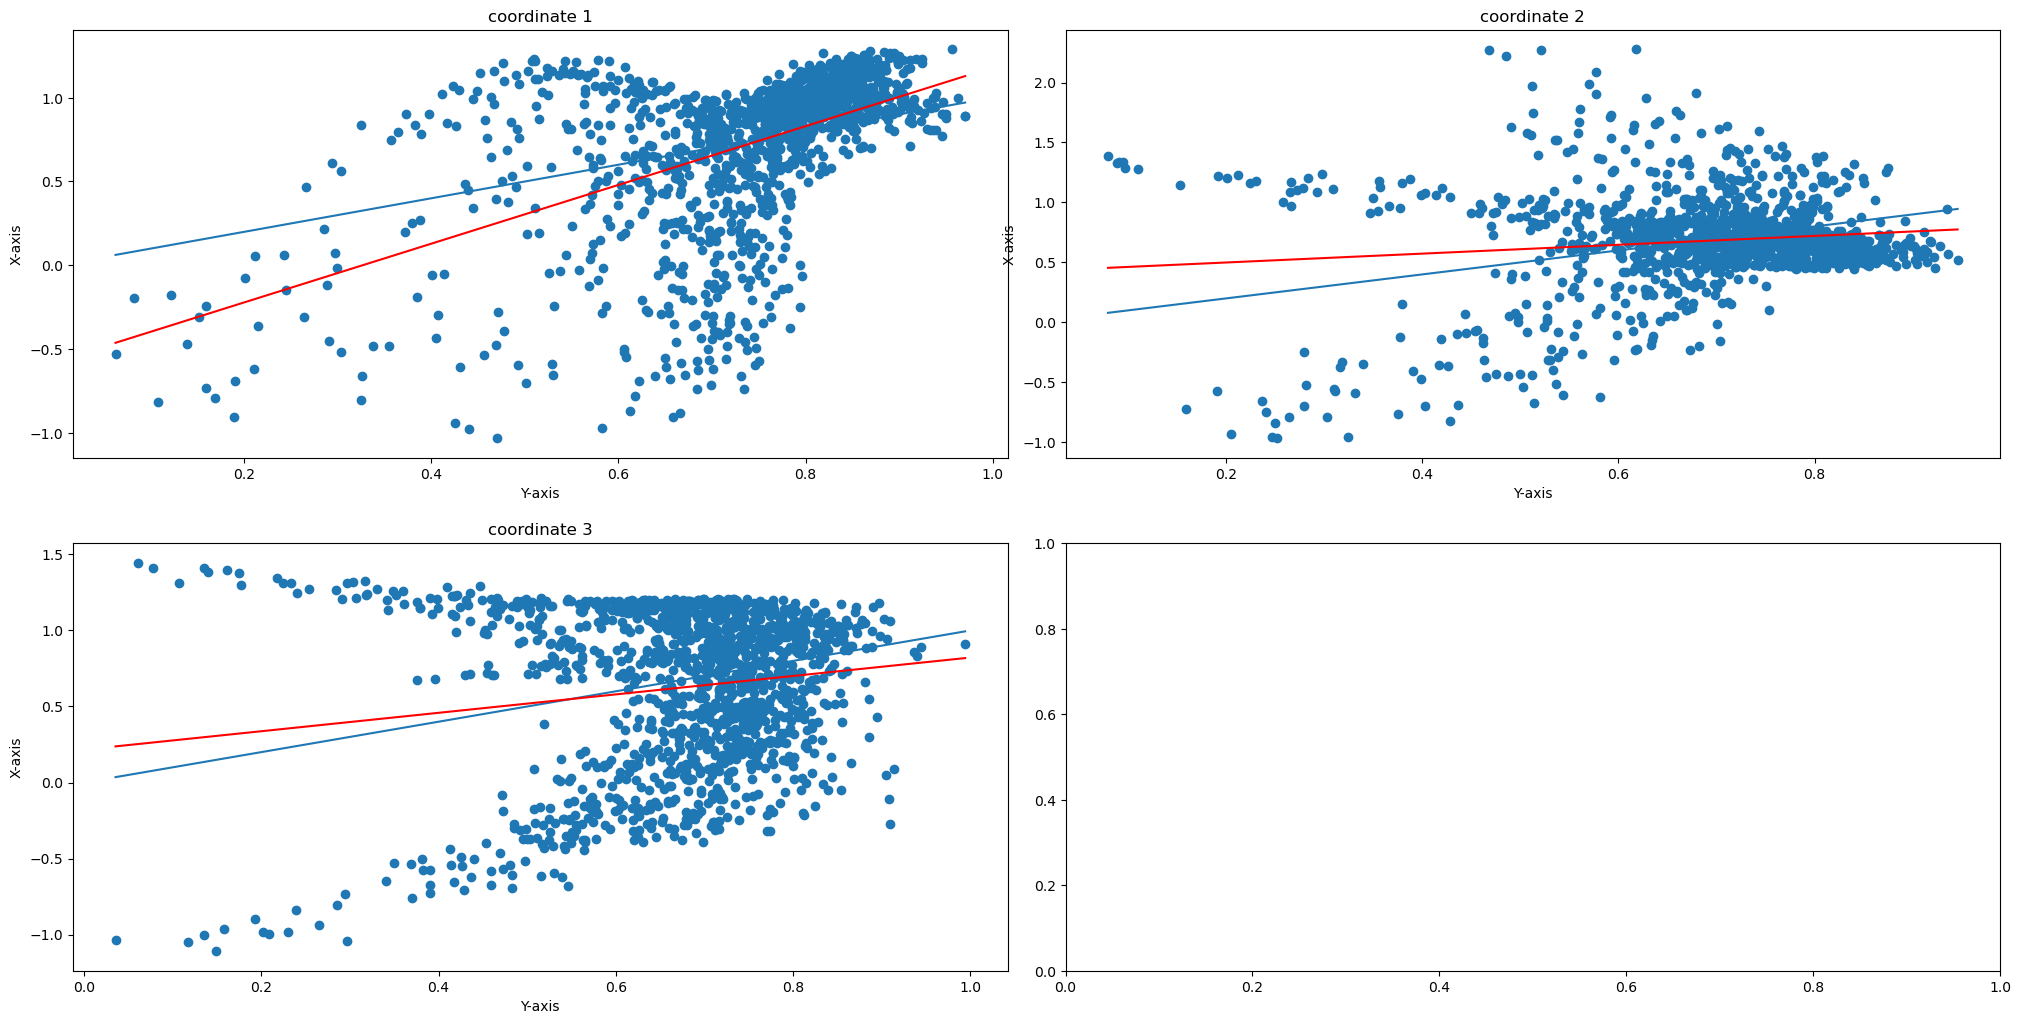

In [94]:
# correlation plots

ig1, axs = plt.subplots(2, 2, figsize=(20, 10), dpi = 100)
plt.tight_layout()
plt.subplots_adjust(hspace=0.2)
# plt.subplots_adjust(vspace=0.2)

axs[0][0].set_xlabel("Y-axis")
axs[0][0].set_ylabel("X-axis")
axs[0][0].title.set_text(f"coordinate 1")
axs[0][0].scatter(x = test_y_lr[:,0], y = y_hats_lr[:,0])
axs[0][0].plot(np.linspace(np.min(test_y_lr[:,0]), np.max(test_y_lr[:,0]), 20), np.linspace(np.min(test_y_lr[:,0]), np.max(test_y_lr[:,0]), 20))
axs[0][0].plot(np.linspace(np.min(test_y_lr[:,0]), np.max(test_y_lr[:,0]), 20), \
               correlation_check_lr_1.get_parameters()[0,0,0,0]*np.linspace(np.min(test_y_lr[:,0]), np.max(test_y_lr[:,0]), 20)\
               + correlation_check_lr_1.get_parameters()[0,1,0,0], color = 'red')

axs[0][1].set_xlabel("Y-axis")
axs[0][1].set_ylabel("X-axis")
axs[0][1].title.set_text(f"coordinate 2")
axs[0][1].scatter(x = test_y_lr[:,1], y = y_hats_lr[:,1])
axs[0][1].plot(np.linspace(np.min(test_y_lr[:,1]), np.max(test_y_lr[:,1]), 20), np.linspace(np.min(test_y_lr[:,1]), np.max(test_y_lr[:,1]), 20))
axs[0][1].plot(np.linspace(np.min(test_y_lr[:,1]), np.max(test_y_lr[:,1]), 20), \
               correlation_check_lr_2.get_parameters()[0,0,0,0]*np.linspace(np.min(test_y_lr[:,1]), np.max(test_y_lr[:,1]), 20)\
               + correlation_check_lr_2.get_parameters()[0,1,0,0], color = 'red')


axs[1][0].set_xlabel("Y-axis")
axs[1][0].set_ylabel("X-axis")
axs[1][0].title.set_text(f"coordinate 3")
axs[1][0].scatter(x = test_y_lr[:,2], y = y_hats_lr[:,2])
axs[1][0].plot(np.linspace(np.min(test_y_lr[:,2]), np.max(test_y_lr[:,2]), 20), np.linspace(np.min(test_y_lr[:,2]), np.max(test_y_lr[:,2]), 20))
axs[1][0].plot(np.linspace(np.min(test_y_lr[:,2]), np.max(test_y_lr[:,2]), 20), \
               correlation_check_lr_3.get_parameters()[0,0,0,0]*np.linspace(np.min(test_y_lr[:,2]), np.max(test_y_lr[:,2]), 20)\
               + correlation_check_lr_3.get_parameters()[0,1,0,0], color = 'red')

## 2.7. Production

In [105]:
# consider mins and maxes as well

In [106]:
x_lr = test_x_lr[0,:]
y_lr = model_lr.forward(x_lr)
print("given x :", x_lr)
print("predicted coordinates :", y_lr)

given x : [0.99712576 0.9885376  0.99142452 0.65609197 0.09743001 0.51526015
 0.65545779 0.65767176 0.54371621 0.09884306]
predicted coordinates : [[0.80560514 0.72595126 0.99615268]]


# 3. Polynomial Regression

Generalised Regression with polynomial kernel - Now, it turns out that the position only
depends on the magnitude of the force along 2 basis vectors (features 1 and 2). That is, the
recordings in Q1 are derived quantities from these two independent features and share a polynomial relationship. Hence, use a polynomial kernel to predict the position of the particle given
the 2 features.

### 3.1. Read Data

In [108]:
path_pr = 'Regression_General_multi/regression_data_multiGen_group_42_train.txt'

In [109]:
np.loadtxt(path_pr, delimiter='\t', skiprows=1)

array([[ -1.38969116,  -0.99749499, -11.31007954,  -4.67358138,
        -22.09817259],
       [ -0.15300525,  -1.00627143,   2.30782695,   5.21017603,
         -4.19624131],
       [  1.3584564 ,  -1.2033243 ,  -0.26778833,  -4.10540905,
         -9.78360577],
       ...,
       [  1.26243024,  -1.22044593,   5.60525899,  -0.60337752,
         -6.88396508],
       [ -1.0525224 ,  -0.6683592 ,  -4.19253655,   0.53300425,
        -10.18814376],
       [ -1.42905366,  -0.1220017 ,  -1.59750217,  -1.2687466 ,
         -9.54663932]])

In [110]:
# file_path = '/content/drive/My Drive/prnn_q5.txt'
df_pr = np.loadtxt(path_pr, delimiter='\t', skiprows=1) # shape = (n, 26)

print(df_pr.shape)
mins_pr = np.min(df_pr[:,:], axis = 0, keepdims = True)
maxs_pr = np.max(df_pr[:,:], axis = 0, keepdims = True)

# Normalisation
df_pr[:,:] = (df_pr[:,:] - mins_pr)/(maxs_pr - mins_pr)


(14000, 5)


In [111]:
# df = undersample(df,  3)

In [112]:
df_pr.shape

(14000, 5)

In [113]:
np.random.shuffle(df_pr)

In [114]:
train_last_index_pr = int(df_pr.shape[0]*train_fraction)
validation_last_index_pr = int(df_pr.shape[0]*(train_fraction+validation_fraction))


train_df_pr = df_pr[:train_last_index_pr, :]
train_x_pr = train_df_pr[:, :-3] # shape = (n, 25)
train_y_pr = train_df_pr[:, -3:] # shape = (n, 10)

validation_df_pr = df_pr[:validation_last_index_pr, :]

test_df_pr = df_pr[validation_last_index_pr:, :]
test_x_pr = test_df_pr[:, :-3] # shape = (n, 10)
test_y_pr = test_df_pr[:, -3:] # shape = (n,  3)

In [115]:
print(df_pr.shape, train_df_pr.shape, validation_df_pr.shape, test_df_pr.shape)

(14000, 5) (12600, 5) (12600, 5) (1400, 5)


### 3.2. Start coding

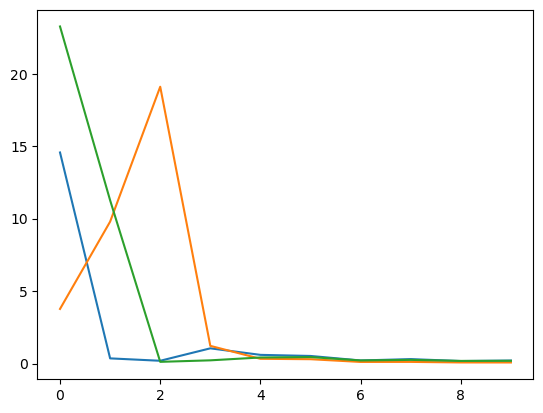

In [116]:
parameters_pr = None #np.load('parameters_regression.npy', allow_pickle=True)
#print(parameters[0][0][0][0])
model_pr = Model(ip_nodes = 2, hidden_nodes = [7,7], op_nodes = 3, \
              intermediate_activations = 'sigmoid', final_activation = 'linear', parameters = parameters_pr)


batch_size_pr = 2**14
lr_pr = 2e-2
n_epochs_pr = 10
print_data_pr = False

# print(train_x.shape, train_y.shape)
losses_pr,_ = model_pr.fit(generator = get_minibatch, x = train_x_pr, y = train_y_pr, lr = lr_pr, \
                   n_epochs = n_epochs_pr, batch_size = batch_size_pr, print_data = print_data_pr)

model_params_pr = model_pr.get_parameters()
#print(model_params[0][0][0][0])
# np.save('parameters.npy', model_params_regression)

losses_pr = np.array(losses_pr).squeeze()
plt.plot(losses_pr)

In [117]:
#np.save('parameters_regression.npy', model_params_regression)

In [118]:
losses_pr[-1]

array([0.21026434, 0.07757005, 0.19334961])

### 3.3.Testing

In [119]:
"""
Confusion matrix whose i-th row and j-th column entry indicates the 
number of samples with true label being i-th class and predicted 
label being j-th class.
"""

'\nConfusion matrix whose i-th row and j-th column entry indicates the \nnumber of samples with true label being i-th class and predicted \nlabel being j-th class.\n'

In [120]:
test_y_pr = test_y_pr.squeeze()
print(test_y_pr.shape, test_x_pr.shape)

(1400, 3) (1400, 2)


### 3.4. Custom Code - Testing

In [121]:
# production
a_pr = model_pr.forward(test_x_pr)

In [122]:
# model.round_the_ops(model.activation1.softmax(model.layer1.z)), axis = 1
y_hats_pr = model_pr.forward(test_x_pr)
y_hats_pr.shape

(1400, 3)

In [123]:
y_hats_pr

array([[0.54360565, 0.55578955, 0.4604376 ],
       [0.65211976, 0.54359314, 0.55247554],
       [1.13337399, 0.91579381, 0.87787324],
       ...,
       [0.49780108, 0.51940555, 0.4272782 ],
       [0.79016764, 0.62617621, 0.67264582],
       [0.02044024, 0.3284432 , 0.00510222]])

In [124]:
# mean squared errors 
errors_pr = np.average(np.square(y_hats_pr - test_y_pr), axis = 0)
errors_pr

array([0.14797395, 0.05845315, 0.1633696 ])

In [125]:
# pearson correlation
r1_pr = np.corrcoef(test_y_pr[0,:].squeeze(), y_hats_pr[0,:].squeeze())
r2_pr = np.corrcoef(test_y_pr[1,:].squeeze(), y_hats_pr[1,:].squeeze())
r3_pr = np.corrcoef(test_y_pr[2,:].squeeze(), y_hats_pr[2,:].squeeze())

In [126]:
print("r1_pr :\n ",r1_pr)
print("r2_pr :\n ",r2_pr)
print("r3_pr :\n ",r3_pr)

r1_pr :
  [[1.         0.54229055]
 [0.54229055 1.        ]]
r2_pr :
  [[1.         0.39673092]
 [0.39673092 1.        ]]
r3_pr :
  [[1.         0.54625166]
 [0.54625166 1.        ]]


In [127]:
# mean squared error

mse_loss_pr = get_mse_loss(test_y_pr, y_hats_pr) # loss = mean square error
mse_loss_pr

array([0.14797395, 0.05845315, 0.1633696 ])

In [128]:
# mean absolute error

mae_loss_pr = get_mae_loss(test_y_pr, y_hats_pr,) # loss = mean square error
mae_loss_pr

array([0.31917748, 0.20175289, 0.33125797])

In [129]:
parameters_for_coerr_pr = np.array([[np.array([1.])[:,np.newaxis], np.array([0.])[:,np.newaxis]]])

In [130]:
correlation_check_pr_1 = Model(ip_nodes = 1, op_nodes = 1, parameters = parameters_for_coerr_pr, final_activation = 'linear')

correlation_losses_pr_1 = correlation_check_pr_1.fit(generator = get_minibatch, batch_size = batch_size_pr,\
                                                     x = test_y_pr[:,0:1], y = y_hats_pr[:,0:1], lr = 1.1*1e-1, n_epochs = 10000)
correlation_losses_pr_1 = np.array(correlation_losses_pr_1)

C:\Users\dharm\AppData\Local\Temp\ipykernel_47836\550332174.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  correlation_losses_pr_1 = np.array(correlation_losses_pr_1)


In [131]:
# plt.plot(correlation_losses_lr_1[:,0,0])
correlation_check_pr_1.get_parameters()

array([[[[2.253390273733836]],

        [[-1.0291883237702304]]]], dtype=object)

In [132]:
correlation_check_pr_2 = Model(ip_nodes = 1, op_nodes = 1, parameters = parameters_for_coerr_pr, final_activation = 'linear')

correlation_losses_pr_2 = correlation_check_pr_2.fit(generator = get_minibatch, batch_size = batch_size_pr,\
                                                     x = test_y_pr[:,1:2], y = y_hats_pr[:,1:2], lr = 1.1*1e-1, n_epochs = 10000)
correlation_losses_pr_2 = np.array(correlation_losses_pr_2)

C:\Users\dharm\AppData\Local\Temp\ipykernel_47836\1457235298.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  correlation_losses_pr_2 = np.array(correlation_losses_pr_2)


In [133]:
# plt.plot(correlation_losses_lr_2[:,0,0])
correlation_check_pr_2.get_parameters()

array([[[[0.3370912044376647]],

        [[0.39340416035910614]]]], dtype=object)

In [134]:
correlation_check_pr_3 = Model(ip_nodes = 1, op_nodes = 1, parameters = parameters_for_coerr_pr, final_activation = 'linear')

correlation_losses_pr_3 = correlation_check_pr_3.fit(generator = get_minibatch, batch_size = batch_size_pr,\
                                                     x = test_y_pr[:,2:], y = y_hats_pr[:,2:], lr = 1.1*1e-1, n_epochs = 10000)
correlation_losses_pr_3 = np.array(correlation_losses_pr_3)

C:\Users\dharm\AppData\Local\Temp\ipykernel_47836\455317938.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  correlation_losses_pr_3 = np.array(correlation_losses_pr_3)


In [135]:
#plt.plot(correlation_losses_lr_3[:,0,0])
correlation_check_pr_3.get_parameters()

array([[[[0.36781609889165356]],

        [[0.26964016122036844]]]], dtype=object)

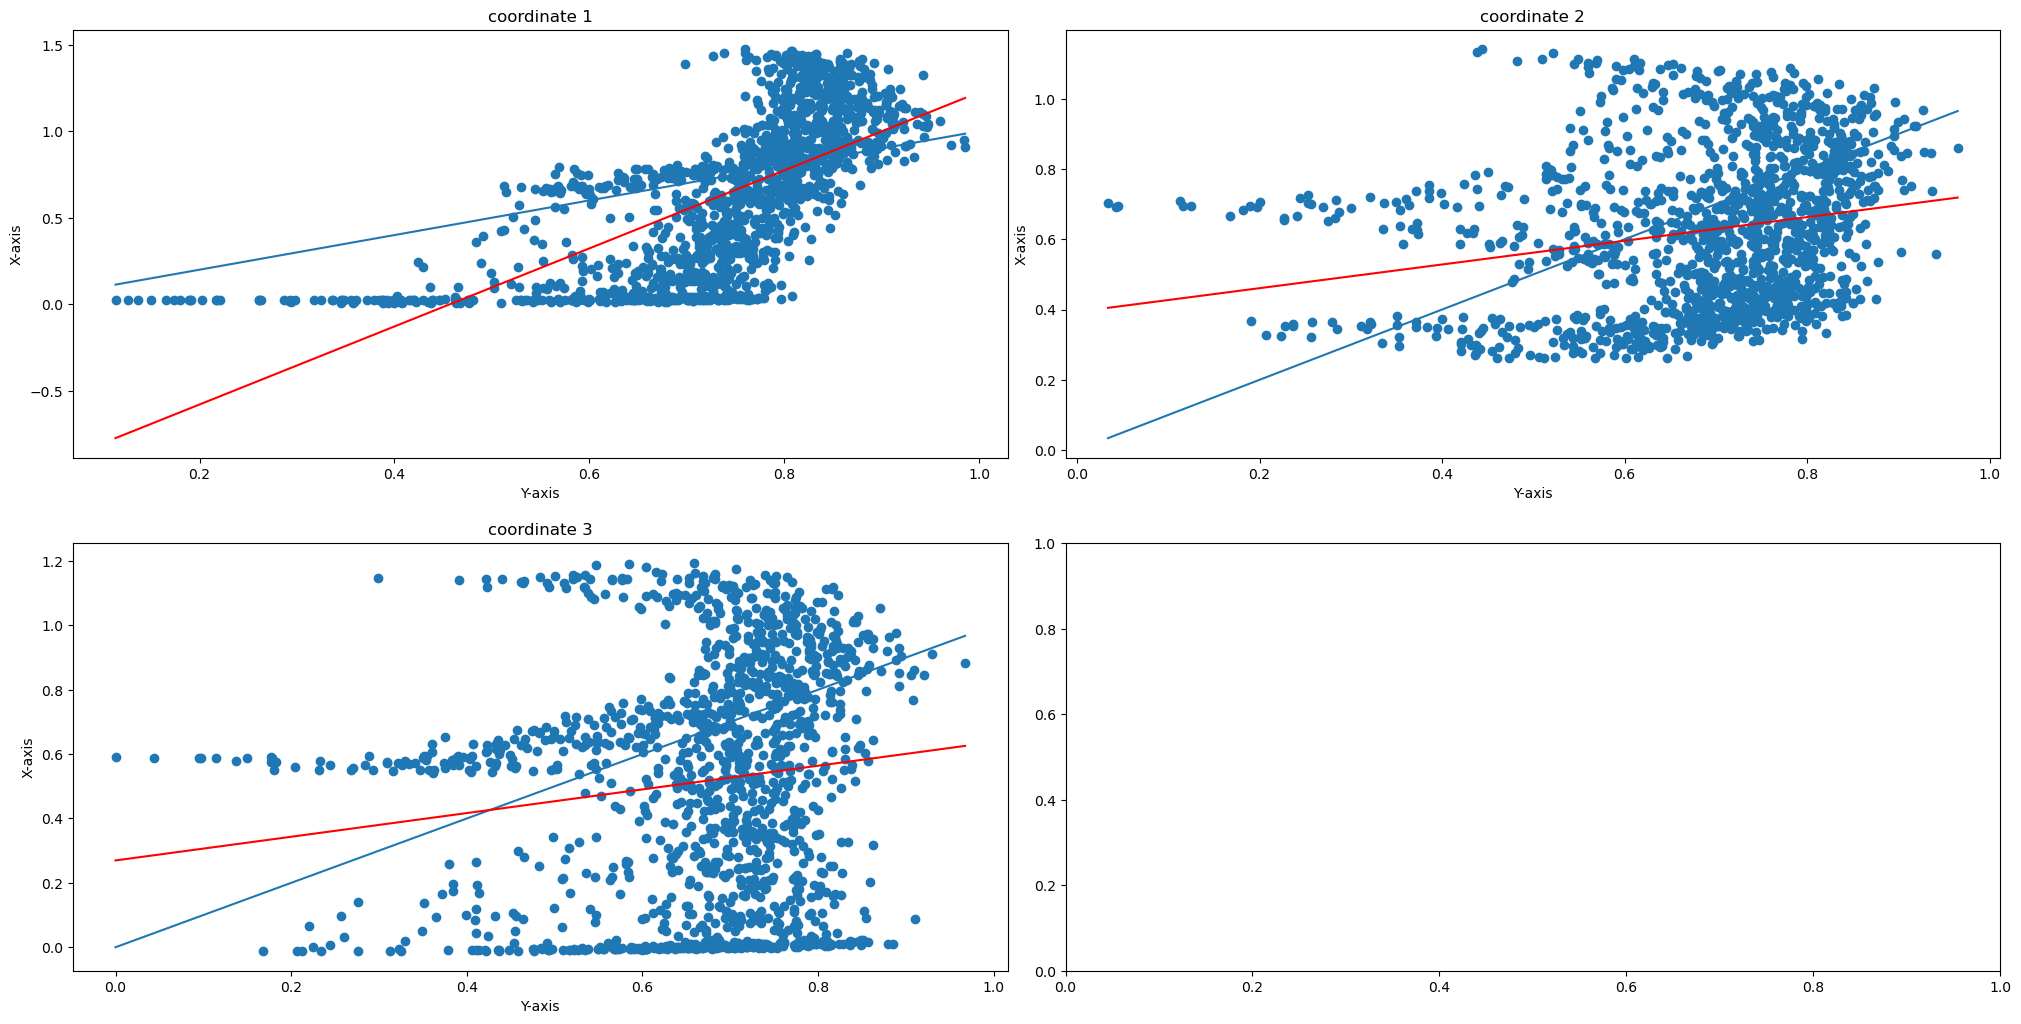

In [136]:
# correlation plots

ig1, axs = plt.subplots(2, 2, figsize=(20, 10), dpi = 100)
plt.tight_layout()
plt.subplots_adjust(hspace=0.2)
# plt.subplots_adjust(vspace=0.2)

axs[0][0].set_xlabel("Y-axis")
axs[0][0].set_ylabel("X-axis")
axs[0][0].title.set_text(f"coordinate 1")
axs[0][0].scatter(x = test_y_pr[:,0], y = y_hats_pr[:,0])
axs[0][0].plot(np.linspace(np.min(test_y_pr[:,0]), np.max(test_y_pr[:,0]), 20), np.linspace(np.min(test_y_pr[:,0]), np.max(test_y_pr[:,0]), 20))
axs[0][0].plot(np.linspace(np.min(test_y_pr[:,0]), np.max(test_y_pr[:,0]), 20), \
               correlation_check_pr_1.get_parameters()[0,0,0,0]*np.linspace(np.min(test_y_pr[:,0]), np.max(test_y_pr[:,0]), 20)\
               + correlation_check_pr_1.get_parameters()[0,1,0,0], color = 'red')

axs[0][1].set_xlabel("Y-axis")
axs[0][1].set_ylabel("X-axis")
axs[0][1].title.set_text(f"coordinate 2")
axs[0][1].scatter(x = test_y_pr[:,1], y = y_hats_pr[:,1])
axs[0][1].plot(np.linspace(np.min(test_y_pr[:,1]), np.max(test_y_pr[:,1]), 20), np.linspace(np.min(test_y_pr[:,1]), np.max(test_y_pr[:,1]), 20))
axs[0][1].plot(np.linspace(np.min(test_y_pr[:,1]), np.max(test_y_pr[:,1]), 20), \
               correlation_check_pr_2.get_parameters()[0,0,0,0]*np.linspace(np.min(test_y_pr[:,1]), np.max(test_y_pr[:,1]), 20)\
               + correlation_check_pr_2.get_parameters()[0,1,0,0], color = 'red')


axs[1][0].set_xlabel("Y-axis")
axs[1][0].set_ylabel("X-axis")
axs[1][0].title.set_text(f"coordinate 3")
axs[1][0].scatter(x = test_y_pr[:,2], y = y_hats_pr[:,2])
axs[1][0].plot(np.linspace(np.min(test_y_pr[:,2]), np.max(test_y_pr[:,2]), 20), np.linspace(np.min(test_y_pr[:,2]), np.max(test_y_pr[:,2]), 20))
axs[1][0].plot(np.linspace(np.min(test_y_pr[:,2]), np.max(test_y_pr[:,2]), 20), \
               correlation_check_pr_3.get_parameters()[0,0,0,0]*np.linspace(np.min(test_y_pr[:,2]), np.max(test_y_pr[:,2]), 20)\
               + correlation_check_pr_3.get_parameters()[0,1,0,0], color = 'red')

In [137]:
# plotting the data
train_x_pr

array([[0.12923602, 0.63930025],
       [0.71546564, 0.03174294],
       [0.77013572, 0.06060171],
       ...,
       [0.90892647, 0.65732983],
       [0.48896175, 0.27450588],
       [0.99305911, 0.86478632]])

In [138]:
train_y_pr

array([[0.6490499 , 0.65507483, 0.65644539],
       [0.88591293, 0.69160614, 0.65804961],
       [0.85655235, 0.81518793, 0.57624863],
       ...,
       [0.87460779, 0.51717494, 0.6354515 ],
       [0.71782842, 0.84097497, 0.78631442],
       [0.69383528, 0.29370025, 0.36093661]])

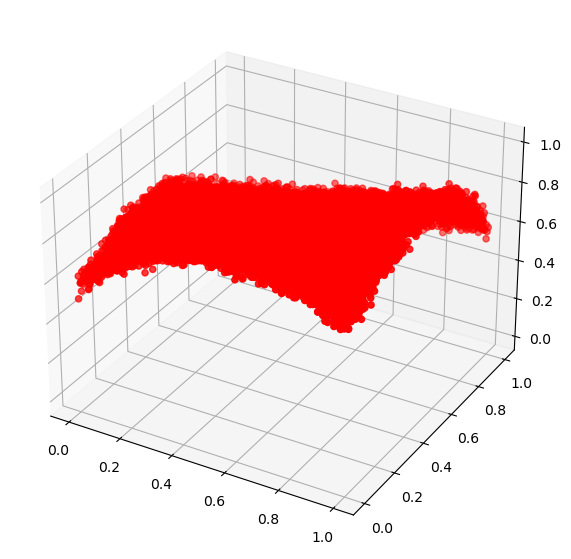

In [139]:
# Creating figure

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.scatter3D(train_x_pr[:,0].squeeze(), train_x_pr[:,1].squeeze(),train_y_pr[:,0].squeeze(), color = 'red')


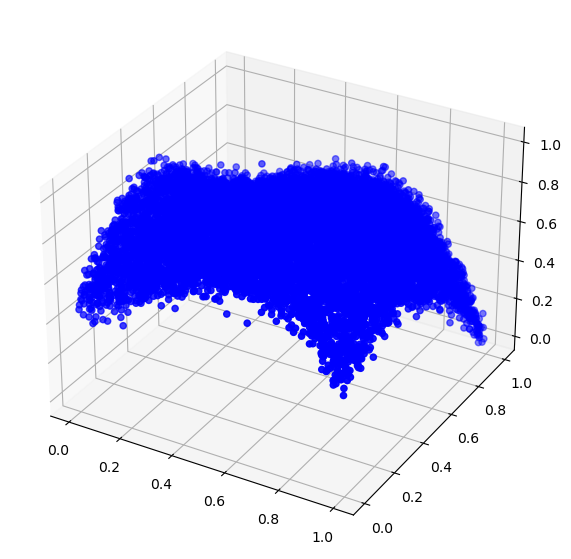

In [140]:

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.scatter3D(train_x_pr[:,0].squeeze(), train_x_pr[:,1].squeeze(),train_y_pr[:,1].squeeze(), color = 'blue')

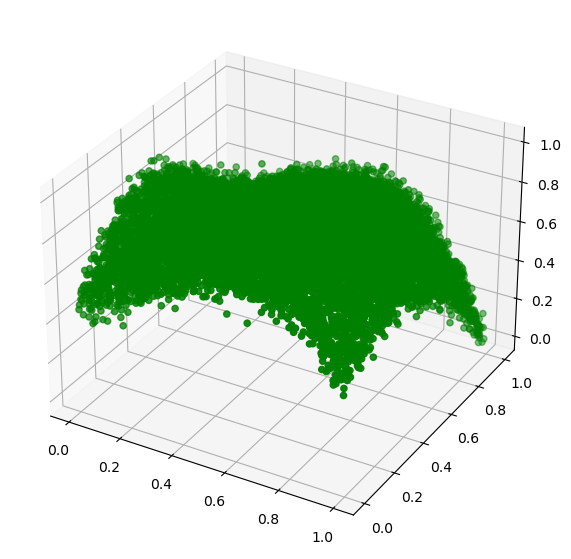

In [141]:

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.scatter3D(train_x_pr[:,0].squeeze(), train_x_pr[:,1].squeeze(),train_y_pr[:,1].squeeze(), color = 'green')

### 3.7. Production

In [152]:
# consider mins and maxes as well

In [153]:
x_pr = test_x_pr[0,:]
y_pr = model_pr.forward(x_pr)
print("given x :", x_pr)
print("predicted coordinates :", y_pr)

given x : [0.54236039 0.78165104]
predicted coordinates : [[0.54360565 0.55578955 0.4604376 ]]


# 4. Non-polynomial Regression Task

 Generalised Regression with non-polynomial kernel - The probability of rain on a particular
day depends non-linearly on 5 satellite readings. You need to figure out the generalised regression
function that predicts the probability of rain given these features

### 4.1. Read Data

In [155]:
path_npr = 'Regression_Non_linear_Uni/regression_data_uni_group_42_train.txt'

In [156]:
np.loadtxt(path_npr, delimiter='\t', skiprows=1)

array([[-0.57599775, -0.54467183, -0.98766998,  0.83864927, -0.15655032,
         0.07126514],
       [ 1.33578516,  0.97251174, -0.76158985,  0.23285384, -0.64805934,
         0.97737878],
       [ 1.36487053,  0.9788721 , -0.81516785,  0.20447349, -0.5792248 ,
         0.99689776],
       ...,
       [ 1.4863759 ,  0.99643871, -0.96810042,  0.08432019, -0.25056253,
         0.99929063],
       [ 0.02306014,  0.02305809,  0.06912524,  0.99973413,  0.99760799,
         0.01061321],
       [ 1.42074582,  0.98876353, -0.90038118,  0.14948807, -0.43510197,
         0.99895589]])

In [157]:
# file_path = '/content/drive/My Drive/prnn_q5.txt'
df_npr = np.loadtxt(path_npr, delimiter='\t', skiprows=1) # shape = (n, 26)

print(df_npr.shape)
mins_npr = np.min(df_npr[:,:], axis = 0, keepdims = True)
maxs_npr = np.max(df_npr[:,:], axis = 0, keepdims = True)

# Normalisation
df_npr[:,:] = (df_npr[:,:] - mins_npr)/(maxs_npr - mins_npr)


(7000, 6)


In [158]:
# df = undersample(df,  3)

In [159]:
df_npr.shape

(7000, 6)

In [160]:
np.random.shuffle(df_npr)

In [161]:
train_last_index_npr = int(df_npr.shape[0]*train_fraction)
validation_last_index_npr = int(df_npr.shape[0]*(train_fraction+validation_fraction))


train_df_npr = df_npr[:train_last_index_npr, :]
train_x_npr = train_df_npr[:, :-1] # shape = (n, 25)
train_y_npr = train_df_npr[:, -1:] # shape = (n, 10)

validation_df_npr = df_npr[:validation_last_index_npr, :]

test_df_npr = df_npr[validation_last_index_npr:, :]
test_x_npr = test_df_npr[:, :-1] # shape = (n, 10)
test_y_npr = test_df_npr[:, -1:] # shape = (n,  3)

In [162]:
print(df_npr.shape, train_df_npr.shape, validation_df_npr.shape, test_df_npr.shape)

(7000, 6) (6300, 6) (6300, 6) (700, 6)


### 4.2. Start coding

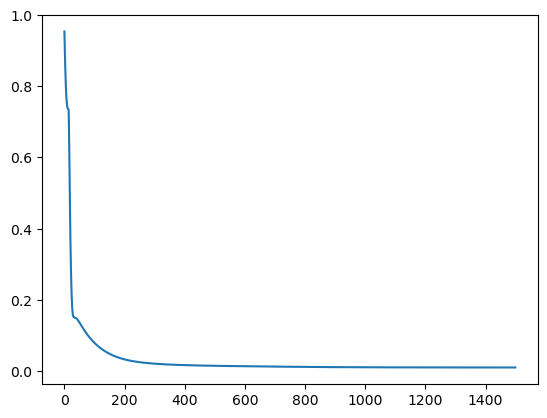

In [163]:
parameters_npr = None #np.load('parameters_regression.npy', allow_pickle=True)
#print(parameters[0][0][0][0])
model_npr = Model(ip_nodes = 5, hidden_nodes = [7,7], op_nodes = 1, \
              intermediate_activations = 'sigmoid', final_activation = 'linear', parameters = parameters_npr)


batch_size_npr = 2**14
lr_npr = 2e-2
n_epochs_npr = 1500
print_data_npr = False

# print(train_x.shape, train_y.shape)
losses_npr,_ = model_npr.fit(generator = get_minibatch, x = train_x_npr, y = train_y_npr, lr = lr_npr, \
                   n_epochs = n_epochs_npr, batch_size = batch_size_npr, print_data = print_data_npr)

model_params_npr = model_npr.get_parameters()
#print(model_params[0][0][0][0])
# np.save('parameters.npy', model_params_regression)

losses_npr = np.array(losses_npr).squeeze()
plt.plot(losses_npr)

In [164]:
#np.save('parameters_regression.npy', model_params_regression)

In [165]:
losses_npr[-1]

0.009618730302766264

### 4.3.Testing

In [166]:
"""
Confusion matrix whose i-th row and j-th column entry indicates the 
number of samples with true label being i-th class and predicted 
label being j-th class.
"""

'\nConfusion matrix whose i-th row and j-th column entry indicates the \nnumber of samples with true label being i-th class and predicted \nlabel being j-th class.\n'

In [167]:
test_y_npr = test_y_npr.squeeze()
print(test_y_npr.shape, test_x_npr.shape)

(700,) (700, 5)


### 4.4. Custom Code - Testing

In [168]:
test_y_npr = test_y_npr[:, np.newaxis]

In [169]:
# production
a_npr = model_npr.forward(test_x_npr)

In [170]:
# model.round_the_ops(model.activation1.softmax(model.layer1.z)), axis = 1
y_hats_npr = model_npr.forward(test_x_npr)
y_hats_npr.shape

(700, 1)

In [171]:
# y_hats_npr

In [172]:
# mean squared errors 
errors_npr = np.average(np.square(y_hats_npr - test_y_npr), axis = 0)
errors_npr[::50]

array([0.00864567])

In [173]:
test_y_npr.shape

(700, 1)

In [174]:
y_hats_npr.shape

(700, 1)

In [175]:
# pearson correlation
r1_npr = np.corrcoef(test_y_npr.squeeze(), y_hats_npr.squeeze())


In [176]:
print("r1_npr :\n ",r1_npr)

r1_npr :
  [[1.         0.96860208]
 [0.96860208 1.        ]]


In [177]:
# mean squared error

mse_loss_npr = get_mse_loss(test_y_npr, y_hats_npr) # loss = mean square error
mse_loss_npr

array([0.00864567])

In [178]:
# mean absolute error

mae_loss_npr = get_mae_loss(test_y_npr, y_hats_npr) # loss = mean square error
mae_loss_npr

array([0.06120823])

In [179]:
parameters_for_coerr_npr = np.array([[np.array([1.])[:,np.newaxis], np.array([0.])[:,np.newaxis]]])

In [180]:
correlation_check_npr_1 = Model(ip_nodes = 1, op_nodes = 1, parameters = parameters_for_coerr_npr, final_activation = 'linear')

correlation_losses_npr_1 = correlation_check_npr_1.fit(generator = get_minibatch, batch_size = batch_size_npr,\
                                                     x = test_y_npr[:,0:1], y = y_hats_npr[:,0:1], lr = 1.1*1e-1, n_epochs = 10000)
correlation_losses_npr_1 = np.array(correlation_losses_npr_1)

C:\Users\dharm\AppData\Local\Temp\ipykernel_47836\4279666920.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  correlation_losses_npr_1 = np.array(correlation_losses_npr_1)


In [181]:
# plt.plot(correlation_losses_lr_1[:,0,0])
correlation_check_npr_1.get_parameters()

array([[[[0.9395280359754005]],

        [[0.005308801430812982]]]], dtype=object)

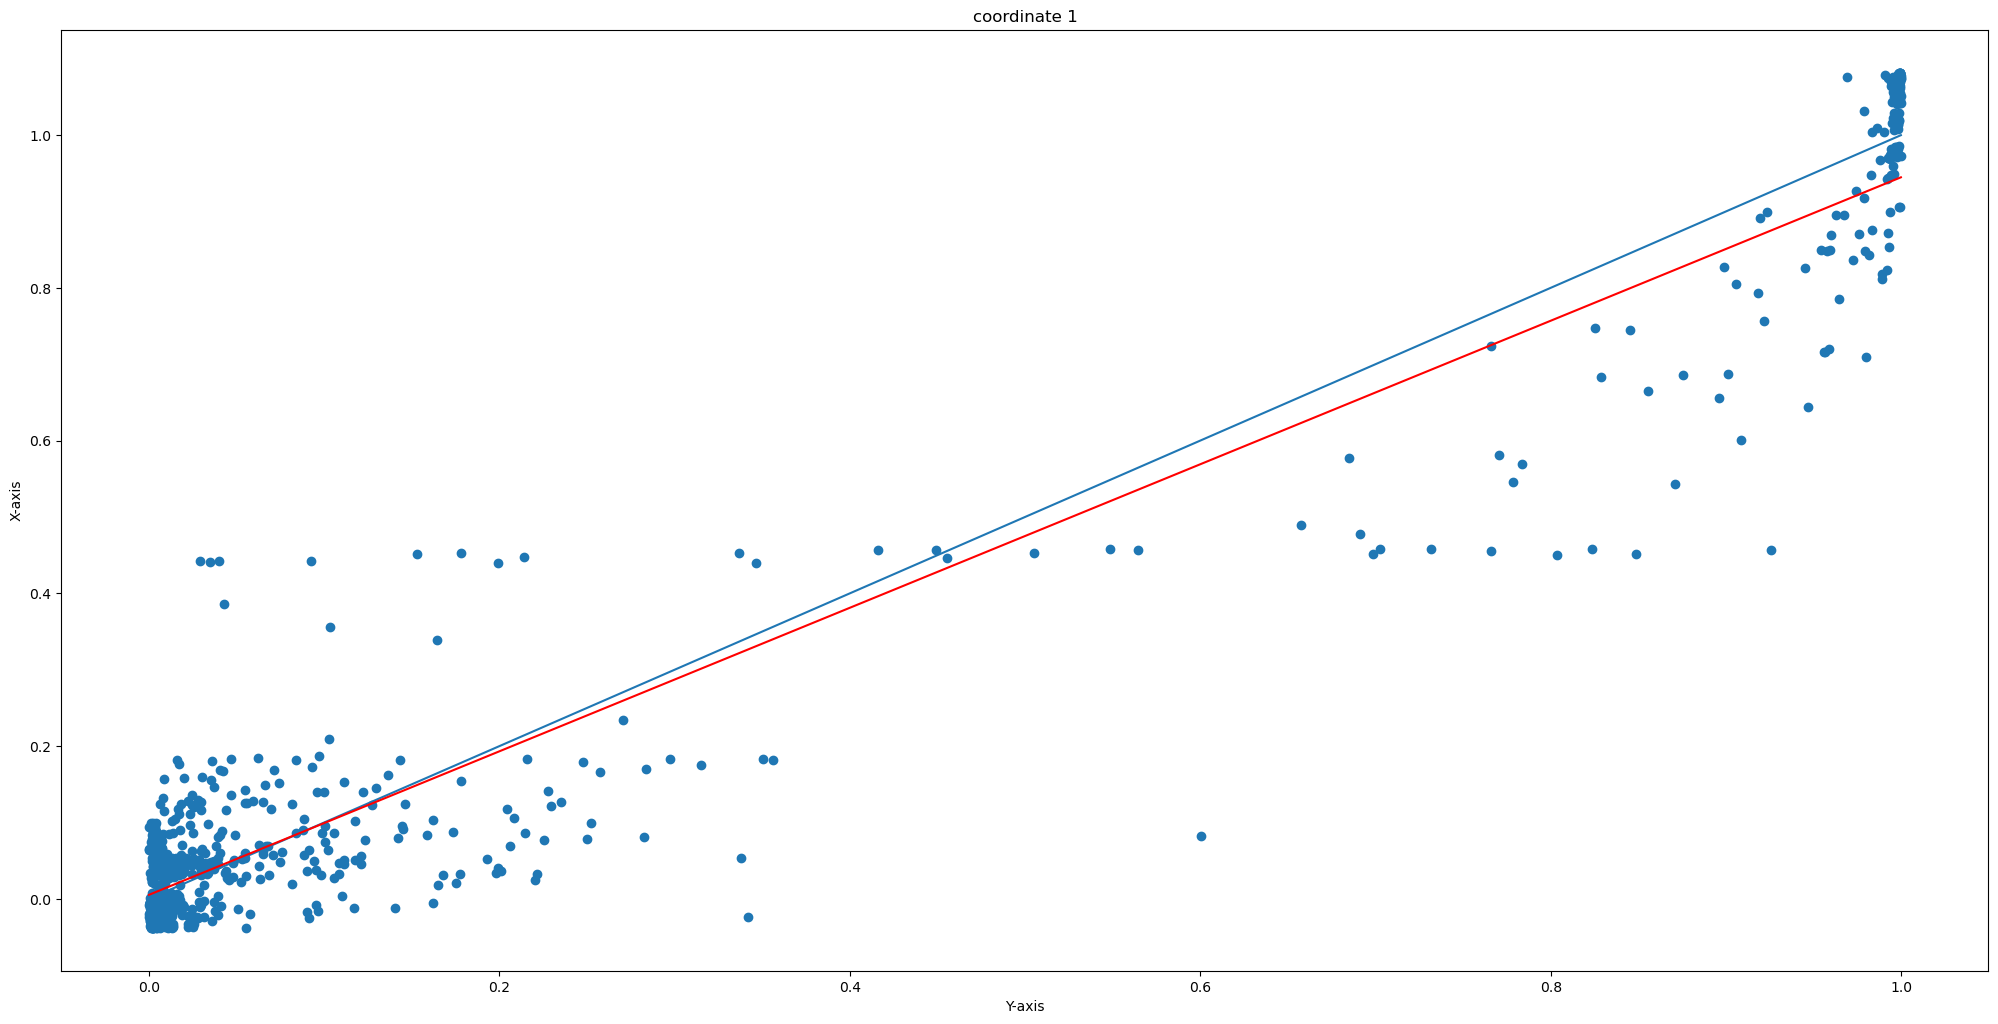

In [182]:
# correlation plots

ig1, axs = plt.subplots(1, 1, figsize=(20, 10), dpi = 100)
plt.tight_layout()
plt.subplots_adjust(hspace=0.2)
# plt.subplots_adjust(vspace=0.2)

axs.set_xlabel("Y-axis")
axs.set_ylabel("X-axis")
axs.title.set_text(f"coordinate 1")
axs.scatter(x = test_y_npr[:,0], y = y_hats_npr[:,0])
axs.plot(np.linspace(np.min(test_y_npr[:,0]), np.max(test_y_npr[:,0]), 20), np.linspace(np.min(test_y_npr[:,0]), np.max(test_y_npr[:,0]), 20))
axs.plot(np.linspace(np.min(test_y_npr[:,0]), np.max(test_y_npr[:,0]), 20), \
               correlation_check_npr_1.get_parameters()[0,0,0,0]*np.linspace(np.min(test_y_npr[:,0]), np.max(test_y_npr[:,0]), 20)\
               + correlation_check_npr_1.get_parameters()[0,1,0,0], color = 'red')

### 4.7. Production

In [193]:
# consider mins and maxes as well

In [194]:
x_npr = test_x_npr[0,:]
y_npr = model_npr.forward(x_npr)
print("given x :", x_npr)
print("predicted coordinates :", y_npr)

given x : [0.10178328 0.02534694 0.78703616 0.31431999 0.09059766]
predicted coordinates : [[-0.00387516]]


## 6. Japanese MNIST

## 6.1. Read Data

In [37]:
path_train_x = 'kmnist-train-imgs.npz'
path_train_y = 'kmnist-train-labels.npz'
path_test_x = 'kmnist-test-imgs.npz'
path_test_y = 'kmnist-test-labels.npz'

In [38]:
with np.load(path_train_x) as data:
    train_x_jm = data['arr_0']

with np.load(path_train_y) as data:
    train_y_jm = data['arr_0']
    
with np.load(path_test_x) as data:
    test_x_jm = data['arr_0']
    
with np.load(path_test_y) as data:
    test_y_jm = data['arr_0']

In [39]:
train_x_jm.shape

(60000, 28, 28)

In [40]:
test_x_jm.shape

(10000, 28, 28)

In [41]:
train_x_jm =train_x_jm.reshape((train_x_jm.shape[0], train_x_jm.shape[1]*train_x_jm.shape[2]), order = 'C') # C means row major
test_x_jm =test_x_jm.reshape((test_x_jm.shape[0], test_x_jm.shape[1]*test_x_jm.shape[2]), order = 'C')

In [42]:
#normalising the train_x and test_x

mins_jm_t = np.min(train_x_jm, axis = 0, keepdims = True)
maxs_jm_t = np.max(train_x_jm, axis = 0, keepdims = True)

# Normalisation
train_x_jm = (train_x_jm - mins_jm_t)/(maxs_jm_t - mins_jm_t)
test_x_jm = (test_x_jm - mins_jm_t)/(maxs_jm_t - mins_jm_t)


In [43]:
train_x_jm.shape, test_x_jm.shape

((60000, 784), (10000, 784))

In [44]:
test_y_jm = test_y_jm[:,np.newaxis]

In [45]:
train_y_jm = train_y_jm[:,np.newaxis]

## 6.2. Start Coding

In [46]:
# model_jm = None
# model_params_jm = None
# import gc
# gc.collect()

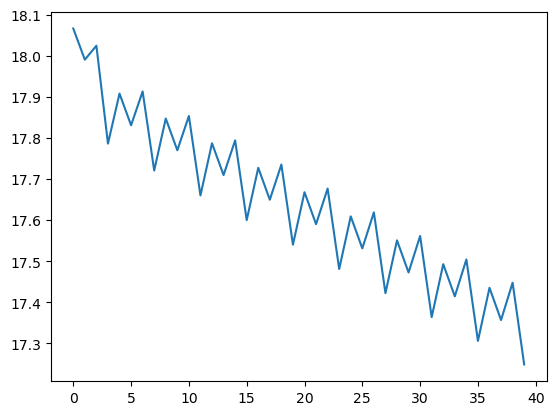

In [52]:

parameters_jm = np.load('parameters_jm.npy', allow_pickle=True)
#print(parameters[0][0][0][0])
model_jm = Model(ip_nodes = 28*28, hidden_nodes = [], op_nodes = 10,\
              intermediate_activations = 'sigmoid',final_activation = 'softmax', parameters = parameters_jm)


batch_size_jm = 2**14
lr_jm = 5e-2
n_epochs_jm = 10
print_data_jm = False
end_after_first_iteration = False

# print(train_x.shape, train_y.shape)
losses_jm, accs_jm = model_jm.fit(generator = get_minibatch, x = train_x_jm, y = train_y_jm, lr = lr_jm, \
                   n_epochs = n_epochs_jm, batch_size = batch_size_jm, print_data = print_data_jm,\
                        end_after_first_iteration = end_after_first_iteration)

model_params_jm = model_jm.get_parameters()
#print(model_params[0][0][0][0])
# np.save('parameters.npy', model_params)

losses_jm = np.array(losses_jm).squeeze()
plt.plot(losses_jm)

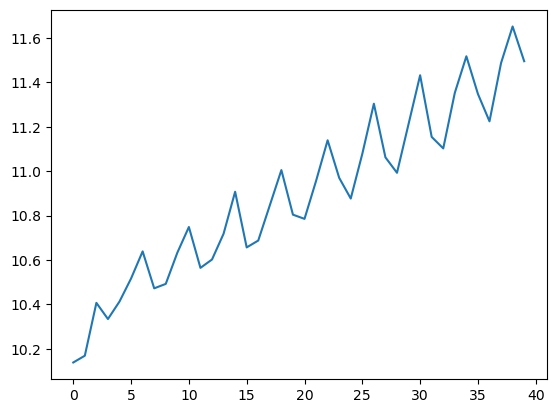

In [53]:
plt.plot(accs_jm)

In [ ]:
# np.save('parameters_jm.npy', model_params_jm)

In [ ]:
losses_jm[::4]

### 6.3. Custom Code - Testing

In [ ]:
test_y_jm = test_y_jm.squeeze()
print(test_x_jm.shape, test_y_jm.shape)

In [ ]:
# production
a_jm = model_jm.forward(test_x_jm)

In [ ]:
# model.round_the_ops(model.activation1.softmax(model.layer1.z)), axis = 1
y_hats_jm = np.argmax(model_jm.forward(test_x_jm), axis =1).squeeze()
print(y_hats_jm.shape, y_hats_jm)

In [ ]:
cm_jm = confusion_matrix(test_y_jm, y_hats_jm)
cm_jm

In [ ]:
# count per class
true_counts_per_class_jm = np.sum(cm_jm, axis = 0)
print("true_counts_per_class : ", true_counts_per_class_jm)

tr_jm = np.trace(cm_jm)
print("trace : ", tr_jm)

tot_jm = np.sum(cm_jm)
print("tot : ", tot_jm)


accuracy_jm = tr_jm/tot_jm
print("accuracy :", accuracy_jm)

## 6.6. Production

In [ ]:
x_jm = test_x_jm[0,:]
y_jm = np.argmax(model_jm.forward(x_jm))
# print("given x :", x_jm)
# print("predicted class :", y_jm)

## 5. Bias_Variance Curves

### 5.1. Without Regularisation

In [ ]:
start = time.time()

In [ ]:
train_x_bv = train_x_pr
train_y_bv = train_y_pr

test_x_bv = test_x_pr
test_y_bv = test_y_pr

In [ ]:
train_x_bv.shape

In [ ]:
parameters_bv = None # np.load('parameters_bv.npy', allow_pickle=True)
# print(parameters[0][0][0][0])


batch_size_bv = 2**14
lr_bv = 2e-2
n_epochs_bv = 500
print_data_bv = False

results = dict({'n_params' : [],
                'training_loss' : [],
                'testing_loss' : []
               })

for itr in range(1,20):
    ip_nodes = 2
    hidden_nodes = [7+5*itr]
    op_nodes = 3

    model_bv = Model(ip_nodes = ip_nodes, hidden_nodes = hidden_nodes, op_nodes = op_nodes, \
                  intermediate_activations = 'relu', final_activation = 'linear', parameters = parameters_bv)


    _ = model_bv.fit(generator = get_minibatch, x = train_x_bv, y = train_y_bv, lr = lr_bv, \
                       n_epochs = n_epochs_bv, batch_size = batch_size_bv, print_data = print_data_bv,\
                    reg = False, power = 2, rp = 1)

    model_params_bv = model_bv.get_parameters()

    results['training_loss'].append(get_mse_loss(model_bv.forward(train_x_bv), train_y_bv))
    results['testing_loss'].append(get_mse_loss(model_bv.forward(test_x_bv), test_y_bv))
    n_params = 0
    arr = [ip_nodes] + hidden_nodes + [op_nodes]

    for i in range(1,len(arr)):
        n_params += arr[i-1]*arr[i] + arr[i]
    
    if itr%5 == 0:
            print("iteration :", itr)
    results['n_params'].append(n_params)

In [ ]:
results

In [ ]:
plt.plot(results['n_params'], np.average(np.array(results['training_loss']), axis = 1))
plt.plot(results['n_params'], np.average(np.array(results['testing_loss']), axis = 1))

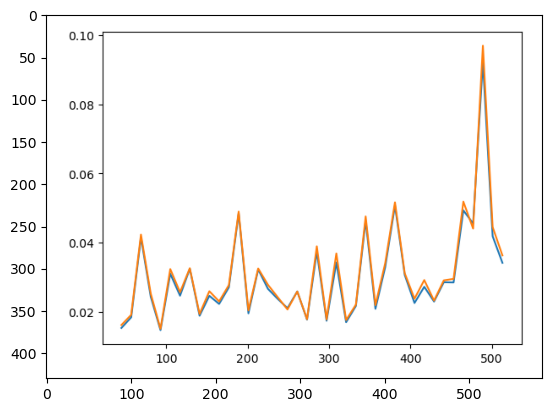

In [51]:
from matplotlib.image import imread

img = imread('bv_graph.png')
plt.imshow(img)

## 5.2 With L2 Regularisation

In [ ]:
start = time.time()

In [ ]:
parameters_bvr = None # np.load('parameters_bv.npy', allow_pickle=True)
# print(parameters[0][0][0][0])


batch_size_bv = 2**14
lr_bv = 2e-2
n_epochs_bv = 500
print_data_bv = False

results_bvr = dict({'n_params' : [],
                'training_loss' : [],
                'testing_loss' : []
               })

for itr in range(1,25):
    ip_nodes = 2
    hidden_nodes = [7+5*itr]
    op_nodes = 3

    model_bvr = Model(ip_nodes = ip_nodes, hidden_nodes = hidden_nodes, op_nodes = op_nodes, \
                  intermediate_activations = 'relu', final_activation = 'linear', parameters = parameters_bv)


    losses = model_bvr.fit(generator = get_minibatch, x = train_x_bv, y = train_y_bv, lr = lr_bv, \
                       n_epochs = n_epochs_bv, batch_size = batch_size_bv, print_data = print_data_bv,\
                    reg = True, power = 2, rp = 1)

    model_params_bvr = model_bvr.get_parameters()

    results_bvr['training_loss'].append(get_mse_loss(model_bv.forward(train_x_bv), train_y_bv))
    results_bvr['testing_loss'].append(get_mse_loss(model_bv.forward(test_x_bv), test_y_bv))
    n_params = 0
    arr = [ip_nodes] + hidden_nodes + [op_nodes]

    for i in range(1,len(arr)):
        n_params += arr[i-1]*arr[i] + arr[i]
    
    print("iteration :", itr)
    results_bvr['n_params'].append(n_params)

In [ ]:
results_bvr

In [ ]:
plt.plot(results_bvr['n_params'], np.average(np.array(results_bvr['training_loss']), axis = 1))
plt.plot(results_bvr['n_params'], np.average(np.array(results_bvr['testing_loss']), axis = 1))

# Convolutional Neural Network

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class SmallConv:
  def __init__(self,inp_channels,num_ker,stride=1,pad=0,ker_size=5):
    self.inp_size=None
    self.ker_size=ker_size
    self.num_ker=num_ker
    self.pad=pad
    self.stride=stride
    self.inp_channels=inp_channels
    self.kernels=np.random.rand(num_ker,inp_channels,ker_size,ker_size)
    self.inp=None

  def patches(self,inp):
        stride = self.stride
        s= self.ker_size
        _,h,w = inp.shape
        x=0
        for i in range(0,h-s,stride):
            y=0
            for j in range(0,w-s,stride):
                im_region = inp[:,i:i+s, j:j+s]
                yield im_region, i,j

  def backpatches(self,inp,stride=None):
        if stride == None:
          stride = self.stride
        s= self.ker_size
        h,w = inp.shape
        x=0
        for i in range(0,h-s,stride):
            y=0
            for j in range(0,w-s,stride):
                im_region = inp[i:i+s, j:j+s]
                yield im_region, i,j

  def forward(self,x):
    k = self.ker_size
    p = self.pad
    s = self.stride
    _,h,w = x.shape
    nk=self.num_ker
    x = np.pad(x, ((0, 0),(p,p),(p,p)), mode='constant', constant_values=0)
    self.inp_size=x.shape
    h = int((h-k+2*p)/s)+1
    w = int((w-k+2*p)/s)+1
    self.inp = x
    output = np.zeros((nk,h,w))
    for z in range(nk):
        for wind,i,j in self.patches(x):
            output[z,i//s,j//s]=np.sum(self.kernels[z]*wind)
    return output


  def back(self,delO,stp=0.01,l=0,b=0):
    p=self.pad
    inp=self.inp
    d=self.stride-1
    ks=self.ker_size
    nk=self.num_ker
    c,h,w=self.inp_size
    inp_ch=self.inp_channels
    num_channels, height, width = delO.shape
    new_height = height + (height - 1) * d
    new_width = width + (width - 1) * d
    dialatedO = np.zeros((num_channels, new_height, new_width))
    dialatedO[:,::d+1,::d+1]=delO[:,:,:]
    delk=np.zeros(self.kernels.shape)
    c,h,w=self.inp_size
    for z in range(nk):
      ker=dialatedO[z,:,:]
      i=0
      for x in range(0,h-new_height):
        j=0
        for y in range(0,w-new_width):
            delk[z,:,i,j]=np.sum(ker*inp[:,x:x+new_height,y:y+new_width])
            j+=1
        i+=1

    pad_dialateO=np.pad(dialatedO, ((0,0),(ks-1,ks-1),(ks-1,ks-1)), mode='constant', constant_values=0)
    delX=np.zeros((c,h,w))
    for z in range(nk):
      channel=pad_dialateO[z,:,:]
      ker=self.kernels[z,:,:]
      for patch,i,j in self.backpatches(channel,1):
        delX[:,i,j]+=np.sum(ker*patch,axis=(1,2))
    outp=delX[:,p:h-p,p:w-p]
    self.kernels=self.kernels-stp*(delk+b+l*self.kernels)
    return outp

In [ ]:
class Flatten:
  def __init__(self):
    self.orig_shape=None
  def forward(self,x):
    self.orig_shape = x.shape
    return x.reshape([-1,1])

  def back(self,x):
    op=x.reshape(self.orig_shape)
    #print("flatten back op",op.shape)
    return op


In [ ]:
class MaxPool:
  def __init__(self,size=5,stride=1):
    self.size=size
    self.inp=None
    self.stride=stride

  def forward(self,x):
    self.inp=x
    channels,h,w=x.shape
    oph=(h-self.size)//self.stride+1
    opw=(w-self.size)//self.stride+1
    op=np.zeros((channels,oph,opw))
    for z in range(channels):
      for i in range(0,oph):
        for j in range(0,opw):
            ist=i*self.stride
            jst=j*self.stride
            op[z,i,j]=np.max(x[z,ist:ist+self.size,jst:jst+self.size])
    return op

  def back(self,delO):
    channels,_,_=self.inp.shape
    _,h,w=delO.shape
    op=np.zeros(self.inp.shape)
    for z in range(channels):
      for x in range(0,h):
        for y in range(0,w):
            xst=x*self.stride
            yst=y*self.stride
            mask = (self.inp[z, xst:xst+self.size, yst:yst+self.size] == np.max(self.inp[z, xst:xst+self.size, yst:yst+self.size]))
            op[z, xst:xst+self.size, yst:yst+self.size] += mask * delO[z, x, y]
    return op

In [ ]:
class ReLU:
  def __init__(self):
    self.map=None

  def forward(self,x):
    mask = (x > 0)
    self.map = mask.astype(int)
    op=self.map*x
    return op

  def back(self,x):
    return x*self.map


In [ ]:
class Dense:
  def __init__(self,inp,out):
    self.inp=inp
    self.out=out
    self.w=np.random.rand(out,inp)
    self.store=None

  def forward(self,x):
    self.store=x
    op=(self.w)@x
    return op

  def back(self,dx,stp=0.01,l=0,b=0):
    z=self.w.T@dx
    self.w=self.w-stp*(dx@(self.store).T+b+l*self.w)
    return z

In [ ]:
class Softmax:
  def __init__(self):
    self.store=None

  def forward(self,x):
    x=x-np.max(x)
    exps = np.exp(x)
    op = exps/np.sum(exps)
    self.store=op
    return op

  def back(self,x):
    softmax_derivative = np.diagflat(self.store) - np.dot(self.store, self.store.T)
    grad = softmax_derivative@x
    return grad

In [ ]:
class SmallModel:
  def __init__(self,l=0,b=0):
    self.l1=SmallConv(1,16,2)
    self.l2=MaxPool(5,2)
    self.l3=ReLU()
    self.l4=Flatten()
    self.l5=Dense(256,10)
    self.l6=ReLU()
    self.l7=Softmax()
    self.l=l
    self.b=b

  def forward(self,x):
    x=self.l1.forward(x)
    x=self.l2.forward(x)
    x=self.l3.forward(x)
    x=self.l4.forward(x)
    x=self.l5.forward(x)
    x=self.l6.forward(x)
    x=self.l7.forward(x)
    return x

  def back(self,y,pred,lr=1,reg=None):
    loss=np.sum(-y*np.log(pred))
    x = -y/pred
    x=self.l7.back(x)
    x=self.l6.back(x)
    x=self.l5.back(x,stp=0.01,l=self.l,b=self.b)
    x=self.l4.back(x)
    x=self.l3.back(x)
    x=self.l2.back(x)
    x=self.l1.back(x,stp=0.01,l=self.l,b=self.b)

    return loss

  def predict(self,x):
    res=self.forward(x)
    return np.argmax(res)


In [ ]:
def randomTrain(setx,sety,size,classes):
    _,c,h,w = setx.shape
    x = np.zeros((size,c,h,w))
    y = np.zeros(size,dtype = int)

    perclass = int(len(sety)/classes)
    new_perclass = int(size/classes)

    for i in range(classes):
        indices =  np.random.permutation(perclass)
        x[i:i+new_perclass,:,:,:] = np.take(setx[i:i+perclass,:,:,:], indices[:new_perclass],axis=0)
        y[i:i+new_perclass] = np.take(sety[i:i+perclass], indices[:new_perclass])

    randomize = np.arange(size)
    np.random.shuffle(randomize)
    p,q = x[randomize[0]],y[randomize[0]]
    x = x[randomize]
    y = y[randomize]
    return x,y

In [ ]:
path = '/content/drive/My Drive/prnn_assn2/'
name = ['kmnist-train-labels.npz','kmnist-test-labels.npz','kmnist-train-imgs.npz','kmnist-test-imgs.npz']

Ytrain = np.load(path+name[0])['arr_0'].reshape(-1,1)
Xtrain = np.load(path+name[2])['arr_0']
xtrain = np.reshape(Xtrain, (Xtrain.shape[0], 1, Xtrain.shape[1], Xtrain.shape[2]))/255
Xtest = np.load(path+name[3])['arr_0']
xtest = np.reshape(Xtest, (Xtest.shape[0], 1, Xtest.shape[1], Xtest.shape[2]))/255
Ytest = np.load(path+name[1])['arr_0'].reshape(-1,1)
print(Xtrain.shape)
train_img,Train_label=randomTrain(xtrain,Ytrain,10000,10)
num_samples = Train_label.shape[0]
train_label = np.zeros((num_samples, 10))
train_label[np.arange(num_samples), Train_label.flatten()] = 1

num_samples = Ytest.shape[0]
ytest = np.zeros((num_samples, 10))
ytest[np.arange(num_samples), Ytest.flatten()] = 1

num_samples = Ytrain.shape[0]
ytrain = np.zeros((num_samples, 10))
ytrain[np.arange(num_samples), Ytrain.flatten()] = 1

(60000, 28, 28)


In [ ]:
model0 = SmallModel()
model1 = SmallModel(l=0.01,b=0.01)
model2 = SmallModel(l=0.0001)
model3 = SmallModel(l=0,b=0.0001)
model4 = SmallModel(l=0.0001,b=0.001)

Best On train data 0.9873
Best On test data 0.5929


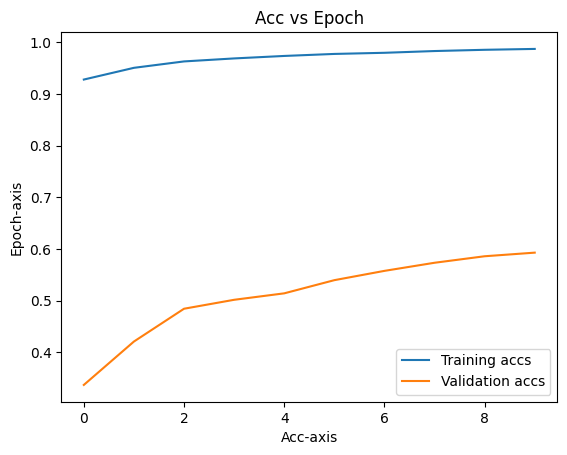

In [ ]:
Valaccs=[]
Vallosses=[]
accs=[]
losses=[]
for _ in range(10):
  acc=los=0
  for x,y in zip(train_img[:],train_label[:]):
    pred=model0.forward(x)
    y=y.reshape((-1,1))
    if np.argmax(pred) == np.argmax(y):
      acc+=1
    los+=model0.back(y,pred)
  losses.append(los/10000)
  accs.append(acc/10000)
  acc=los=0
  for x,y in zip(xtest[:],ytest[:]):
    pred=model0.forward(x)
    y=y.reshape((-1,1))
    los+=np.sum(-y*np.log(pred))
    if np.argmax(pred) == np.argmax(y):
      acc+=1
  Vallosses.append(los/10000)
  Valaccs.append(acc/10000)
  acc=los=0

print("Best On train data",np.max(accs))
print("Best On test data",np.max(Valaccs))

x_values = range(len(accs))
plt.plot(x_values, accs, label='Training accs')
plt.plot(x_values, Valaccs, label='Validation accs')
plt.xlabel('Acc-axis')
plt.ylabel('Epoch-axis')
plt.title('Acc vs Epoch')
plt.legend()
plt.show()

Best On train data 0.9113
Best On test data 0.1


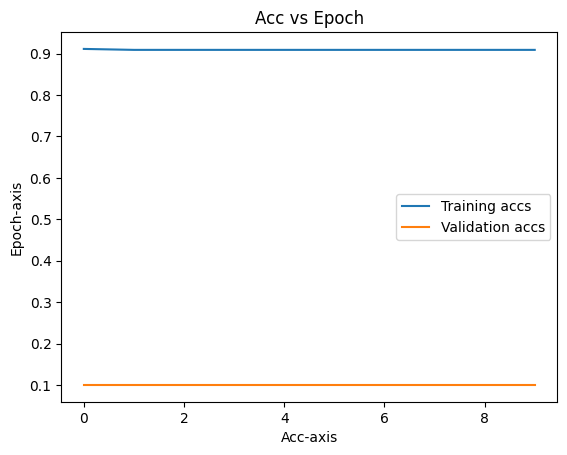

In [ ]:
Valaccs1=[]
Vallosses1=[]
accs1=[]
losses1=[]
for _ in range(10):
  acc=los=0
  for x,y in zip(train_img[:],train_label[:]):
    pred=model1.forward(x)
    y=y.reshape((-1,1))
    if np.argmax(pred) == np.argmax(y):
      acc+=1
    los+=model1.back(y,pred)
  losses1.append(los/10000)
  accs1.append(acc/10000)
  acc=los=0
  for x,y in zip(xtest[:],ytest[:]):
    pred=model1.forward(x)
    y=y.reshape((-1,1))
    los+=np.sum(-y*np.log(pred))
    if np.argmax(pred) == np.argmax(y):
      acc+=1
  Vallosses1.append(los/10000)
  Valaccs1.append(acc/10000)
  acc=los=0

print("Best On train data",np.max(accs1))
print("Best On test data",np.max(Valaccs1))

x_values = range(len(accs1))
plt.plot(x_values, accs1, label='Training accs')
plt.plot(x_values, Valaccs1, label='Validation accs')
plt.xlabel('Acc-axis')
plt.ylabel('Epoch-axis')
plt.title('Acc vs Epoch')
plt.legend()
plt.show()

Best On train data 0.9886
Best On test data 0.6205


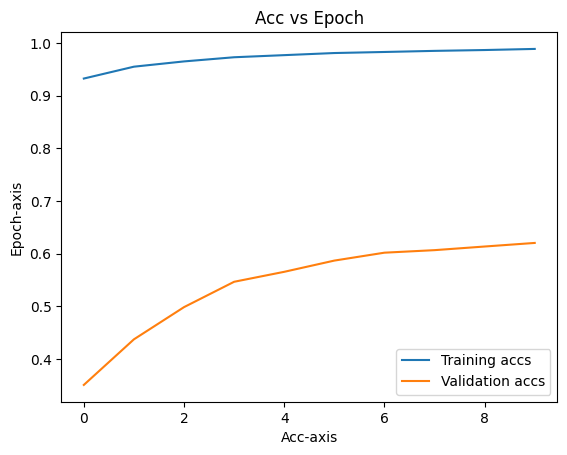

In [ ]:
Valaccs2=[]
Vallosses2=[]
accs2=[]
losses2=[]
for _ in range(10):
  acc=los=0
  for x,y in zip(train_img[:],train_label[:]):
    pred=model2.forward(x)
    y=y.reshape((-1,1))
    if np.argmax(pred) == np.argmax(y):
      acc+=1
    los+=model2.back(y,pred)
  losses2.append(los/10000)
  accs2.append(acc/10000)
  acc=los=0
  for x,y in zip(xtest[:],ytest[:]):
    pred=model2.forward(x)
    y=y.reshape((-1,1))
    los+=np.sum(-y*np.log(pred))
    if np.argmax(pred) == np.argmax(y):
      acc+=1
  Vallosses2.append(los/10000)
  Valaccs2.append(acc/10000)
  acc=los=0

print("Best On train data",np.max(accs2))
print("Best On test data",np.max(Valaccs2))

x_values = range(len(accs2))
plt.plot(x_values, accs2, label='Training accs')
plt.plot(x_values, Valaccs2, label='Validation accs')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('Acc vs Epoch')
plt.legend()
plt.show()

In [ ]:
# x_values = range(len(losses2))
# plt.plot(x_values, losses2, label='Training Loss')
# plt.plot(x_values, Vallosses2, label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Loss vs Epoch')
# plt.legend()
# plt.show()

Best On train data 0.988
Best On test data 0.6042


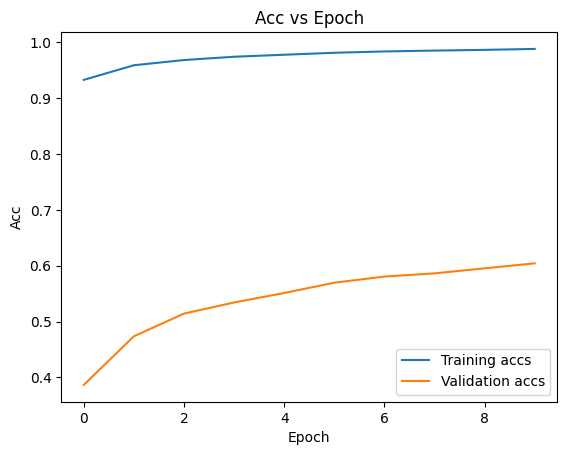

In [ ]:
Valaccs3=[]
Vallosses3=[]
accs3=[]
losses3=[]
for _ in range(10):
  acc=los=0
  for x,y in zip(train_img[:],train_label[:]):
    pred=model3.forward(x)
    y=y.reshape((-1,1))
    if np.argmax(pred) == np.argmax(y):
      acc+=1
    los+=model3.back(y,pred)
  losses3.append(los/10000)
  accs3.append(acc/10000)
  acc=los=0
  for x,y in zip(xtest[:],ytest[:]):
    pred=model3.forward(x)
    y=y.reshape((-1,1))
    los+=np.sum(-y*np.log(pred))
    if np.argmax(pred) == np.argmax(y):
      acc+=1
  Vallosses3.append(los/10000)
  Valaccs3.append(acc/10000)
  acc=los=0

print("Best On train data",np.max(accs3))
print("Best On test data",np.max(Valaccs3))

x_values = range(len(accs3))
plt.plot(x_values, accs3, label='Training accs')
plt.plot(x_values, Valaccs3, label='Validation accs')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('Acc vs Epoch')
plt.legend()
plt.show()

In [ ]:
# x_values = range(len(losses3))
# plt.plot(x_values, losses3, label='Training Loss')
# plt.plot(x_values, Vallosses3, label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Loss vs Epoch')
# plt.legend()
# plt.show()

In [ ]:
Valaccs4=[]
Vallosses4=[]
accs4=[]
losses4=[]
for _ in range(10):
  acc=los=0
  for x,y in zip(train_img[:],train_label[:]):
    pred=model4.forward(x)
    y=y.reshape((-1,1))
    if np.argmax(pred) == np.argmax(y):
      acc+=1
    los+=model4.back(y,pred)
  losses4.append(los/10000)
  accs4.append(acc/10000)
  acc=los=0
  for x,y in zip(xtest[:],ytest[:]):
    pred=model4.forward(x)
    y=y.reshape((-1,1))
    los+=np.sum(-y*np.log(pred))
    if np.argmax(pred) == np.argmax(y):
      acc+=1
  Vallosses4.append(los/10000)
  Valaccs4.append(acc/10000)
  acc=los=0

Best On train data 0.9781
Best On test data 0.583


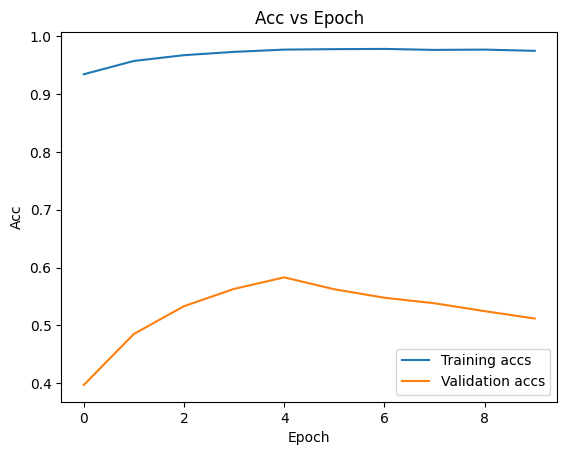

In [ ]:
print("Best On train data",np.max(accs4))
print("Best On test data",np.max(Valaccs4))

x_values = range(len(accs4))
plt.plot(x_values, accs4, label='Training accs')
plt.plot(x_values, Valaccs4, label='Validation accs')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('Acc vs Epoch')
plt.legend()
plt.show()


In [ ]:
model5 = SmallModel(l=0.0001)
Valaccs5=[]
Vallosses5=[]
accs5=[]
losses5=[]
for _ in range(3):
  acc=los=0
  for x,y in zip(xtrain[:],ytrain[:]):
    pred=model5.forward(x)
    y=y.reshape((-1,1))
    if np.argmax(pred) == np.argmax(y):
      acc+=1
    los+=model5.back(y,pred)
  losses5.append(los/70000)
  accs5.append(acc/70000)
  acc=los=0
  for x,y in zip(xtest[:],ytest[:]):
    pred=model5.forward(x)
    y=y.reshape((-1,1))
    los+=np.sum(-y*np.log(pred))
    if np.argmax(pred) == np.argmax(y):
      acc+=1
  Vallosses5.append(los/10000)
  Valaccs5.append(acc/10000)
  acc=los=0

Best On train data 0.7654428571428571
Best On test data 0.7667


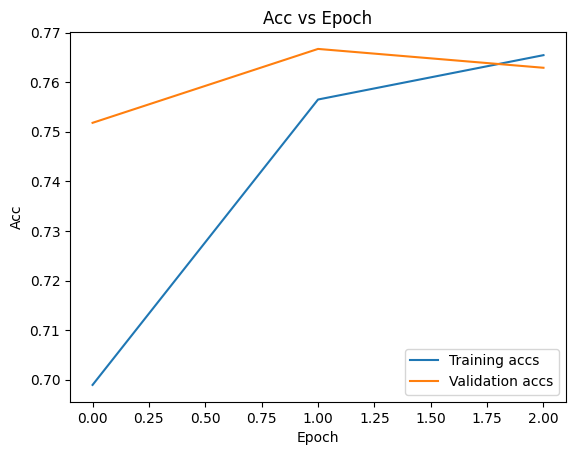

In [ ]:
print("Best On train data",np.max(accs5))
print("Best On test data",np.max(Valaccs5))

x_values = range(len(accs5))
plt.plot(x_values, accs5, label='Training accs')
plt.plot(x_values, Valaccs5, label='Validation accs')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('Acc vs Epoch')
plt.legend()
plt.show()

In [ ]:
model6 = SmallModel(l=0.001)
Valaccs6=[]
Vallosses6=[]
accs6=[]
losses6=[]
for _ in range(5):
  acc=los=0
  for x,y in zip(xtrain[:],ytrain[:]):
    pred=model6.forward(x)
    y=y.reshape((-1,1))
    if np.argmax(pred) == np.argmax(y):
      acc+=1
    los+=model6.back(y,pred)
  losses6.append(los/70000)
  accs6.append(acc/70000)
  acc=los=0
  for x,y in zip(xtest[:],ytest[:]):
    pred=model6.forward(x)
    y=y.reshape((-1,1))
    los+=np.sum(-y*np.log(pred))
    if np.argmax(pred) == np.argmax(y):
      acc+=1
  Vallosses6.append(los/10000)
  Valaccs6.append(acc/10000)
  acc=los=0

Best On train data 0.7674571428571428
Best On test data 0.7654


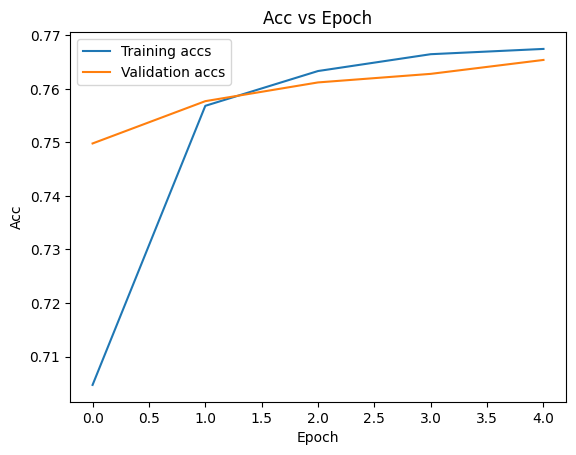

In [ ]:
print("Best On train data",np.max(accs6))
print("Best On test data",np.max(Valaccs6))

x_values = range(len(accs6))
plt.plot(x_values, accs6, label='Training accs')
plt.plot(x_values, Valaccs6, label='Validation accs')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('Acc vs Epoch')
plt.legend()
plt.show()

In [ ]:
model7 = SmallModel()
Valaccs7=[]
Vallosses7=[]
accs7=[]
losses7=[]
for _ in range(5):
  acc=los=0
  for x,y in zip(xtrain[:],ytrain[:]):
    pred=model7.forward(x)
    y=y.reshape((-1,1))
    if np.argmax(pred) == np.argmax(y):
      acc+=1
    los+=model7.back(y,pred)
  losses7.append(los/70000)
  accs7.append(acc/70000)
  acc=los=0
  for x,y in zip(xtest[:],ytest[:]):
    pred=model7.forward(x)
    y=y.reshape((-1,1))
    los+=np.sum(-y*np.log(pred))
    if np.argmax(pred) == np.argmax(y):
      acc+=1
  Vallosses7.append(los/10000)
  Valaccs7.append(acc/10000)
  acc=los=0

<img src="https://drive.google.com/uc?id=1m_oRKh8wfJS4LozWGF2FmKdcPmMCZ4_C"><br>
<img src="https://drive.google.com/uc?id=13uKLOmrLSxWRpltmmK8iJZou39NS0nmv"><br>
<img src="https://drive.google.com/uc?id=1Zld5WEmerfsAh-KBNnaDZyUOb1BzBKhn" width=500 height=500><br>
<img src="https://drive.google.com/uc?id=1Kom3I94Sn4nCwZP0BfkGkF7bfTgneRy_" width=500 height=500>

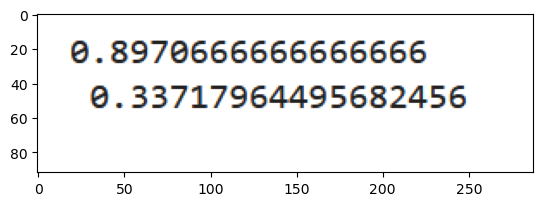

In [63]:

img = imread('plots/1.png')
plt.imshow(img)

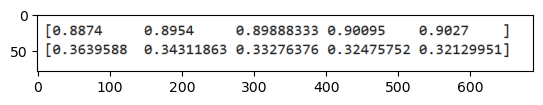

In [64]:

img = imread('plots/2.png')
plt.imshow(img)

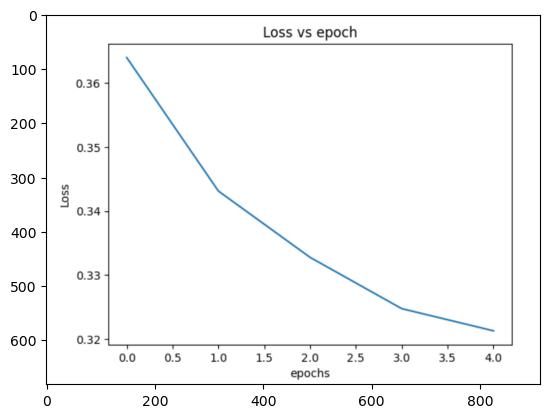

In [66]:

img = imread('plots/3.png')
plt.imshow(img)

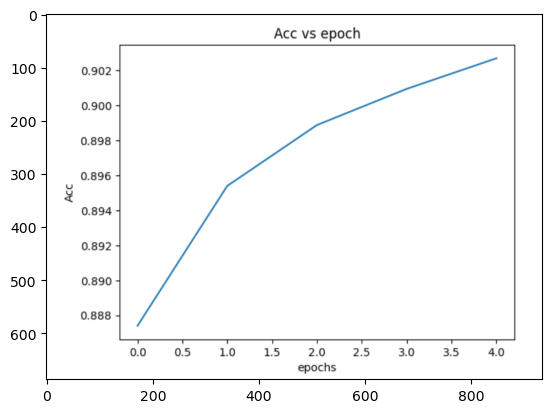

In [67]:

img = imread('plots/4.png')
plt.imshow(img)

# SVM

SVM for multi-class classification

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
import cvxopt
# from cvxopt import matrix
from numpy import array
# from cvxopt import solvers
if __name__=="__main__":
    file_path = "C:/Users/nilad/Downloads/prnn asgmt2/multi_class_classification_data_group_42_train.txt"
    matrics = np.loadtxt(file_path,skiprows=1)
    matrics= matrics.astype(float)
    N=matrics.shape[0]
    test_ratio=0.1
    r=int(test_ratio*N)
    train=matrics[0:r,:]
    test=matrics[r:N,:]
    train_feature=train[:,0:25]
    train_label=train[:,25:26]
    test_feature=test[:,0:25]
    test_label=test[:,25:26]
    val_ratio=0.2
    n1=int(val_ratio*r)
    val_feature=train_feature[0:n1]
    val_label=train_label[n1:r]
    train_feature=train_feature[n1:r]
    train_label=train_label[n1:r]

    def rbf_solver(X,y,gamma,c):
        # r, n1 = X.shape[0], 0  # assuming r and n1 are defined elsewhere
        # K = np.exp(-gamma * np.sum((X[:, np.newaxis] - X[np.newaxis, :])**2, axis=2))
       
        K = np.zeros((r-n1, r-n1))
        for i in range(r-n1):
          for j in range(i, r-n1):
            diff=X[i]-X[j]
            K[i, j] =  np.exp(-gamma * np.dot(diff, diff))*y[i,0]*y[j,0]
            K[j, i] = K[i, j]
        #   print(i)   
        Q = cvxopt.matrix(K)
        p = cvxopt.matrix(np.ones(r - n1))
        diagonal_values = np.vstack((-1*np.eye(r-n1), np.eye(r-n1)))
        G = cvxopt.matrix((diagonal_values))
        vector=np.vstack((np.zeros(r-n1),c*np.ones(r-n1))).reshape(-1,1)
        h = cvxopt.matrix(vector)
        A = cvxopt.matrix(train_label.T) 
        b = cvxopt.matrix(0.0)
        # print(K) 
        sol = cvxopt.solvers.qp(P=Q, q=-p, G=G, h=h, A=A, b=b)
        return sol['x']

    def sigmoid_solver(X,y,gamma,a,c):
        K = np.zeros((r-n1, r-n1))
        for i in range(r-n1):
          for j in range(i, r-n1):
            dot_product = np.dot(X[i], X[j])
            K[i, j] = np.tanh(gamma * dot_product + a)*y[i,0]*y[j,0]
            K[j, i] = K[i, j]
        #print(i)   
        Q = cvxopt.matrix(K)
        p = cvxopt.matrix(np.ones(r - n1))
        diagonal_values = np.vstack((-1*np.eye(r-n1), np.eye(r-n1)))
        G = cvxopt.matrix((diagonal_values))
        vector=np.vstack((np.zeros(r-n1),c*np.ones(r-n1))).reshape(-1,1)
        h = cvxopt.matrix(vector)
        A = cvxopt.matrix(train_label.T) 
        b = cvxopt.matrix(0.0)
       
        sol = cvxopt.solvers.qp(P=Q, q=-p, G=G, h=h, A=A, b=b)
        return sol['x']

    def polynomial_solver(X,y,gamma,a,c):
        K = np.zeros((r-n1, r-n1))
        for i in range(r-n1):
          for j in range(i, r-n1):
            dot_product = np.dot(X[i], X[j])
            K[i, j] = (gamma * dot_product + 1)**a  *  y[i,0]*y[j,0]
            K[j, i] = K[i, j]
        #print(i)   
        Q = cvxopt.matrix(K)
        p = cvxopt.matrix(np.ones(r - n1))
        diagonal_values = np.vstack((-1*np.eye(r-n1), np.eye(r-n1)))
        G = cvxopt.matrix((diagonal_values))
        vector=np.vstack((np.zeros(r-n1),c*np.ones(r-n1))).reshape(-1,1)
        h = cvxopt.matrix(vector)
        A = cvxopt.matrix(train_label.T) 
        b = cvxopt.matrix(0.0)   
       
        sol = cvxopt.solvers.qp(P=Q, q=-p, G=G, h=h, A=A, b=b)
        return sol['x']    
    
    feature_lists = [[] for _ in range(10)]
    label_lists = [[] for _ in range(10)]
    
    for label in range(10):
        ovr_labels = np.where(train_label == label, 1, -1)
        feature_lists[label].append(train_feature)
        label_lists[label].append(ovr_labels)
    
    feature_lists = [np.array(lst) for lst in feature_lists]
    label_lists = [np.array(lst) for lst in label_lists]  
    feature_lists = [np.squeeze(lst, axis=0) for lst in feature_lists] 
    label_lists = [np.squeeze(lst, axis=0) for lst in label_lists] 

    gamma_vals=[0.1,1,10]
    c_vals=[0.001,0.1,1,10]
    a_vals=[0.1,1,10]
    min_err=1000
    kernel_choice = input("Select kernel type (rbf(1) or sigmoid(2) or polynomial(3)):") 
    for gamma in gamma_vals:
       for c in c_vals:
            if kernel_choice=='1':
                lamb_val=[]
                S_indices_list=[]
                for i in range(10):      
                    # kernel=rbf_kernel_matrix(train_feature,gamma)
                    # kernel=array(kernel)
                  
                    lamb=rbf_solver(feature_lists[i],label_lists[i],gamma,c)
                    lamb=np.array(lamb)
                    lamb_val.append(lamb)
                    S_indices = np.where(lamb >0)[0]
                    S_indices_list.append(S_indices)
                    M_indices = np.where(np.logical_and(0 < lamb, lamb < c))[0]
                    bias=np.zeros(10)
                    b=0
                    for n in M_indices:
                        sum_term = 0
                        for m in S_indices:
                            sum_term += lamb[m] * label_lists[i][m] * np.exp(-gamma * np.dot((feature_lists[i][m]-feature_lists[i][n]), (feature_lists[i][m]-feature_lists[i][n])))
                        b += label_lists[i][n] - sum_term
                    bias[i] = b/len(M_indices)
                    # def hyperplane(x):
                    #     sum=0
                    #     for m in S_indices:
                    #         sum+=lamb[m] * label_lists[i][m] * np.exp(-gamma * np.dot((feature_lists[i][m]-x), (feature_lists[i][m]-x)))
                    #     return sum+bias[i]
                
                count=0
                for i in range(n1):
                    pred=np.zeros(10)  
                    for j in range(10):
                        sum=0
                        for m in S_indices_list[j]:
                           sum+=lamb[m] * label_lists[j][m] * np.exp(-gamma * np.dot((feature_lists[j][m]-val_feature[i]), (feature_lists[j][m]-val_feature[i])))
                        pred[j]=sum+bias[j]
                    positive_indices = np.where(pred > 0)[0]
                    if len(positive_indices) == 1:
                        prediction= positive_indices[0]
                    else:
                        
                        max_index = np.argmax(pred)
                        prediction= max_index
  
                    if prediction!=val_label[i]:
                            count+=1
                
                print("Error with c=",c,"and gamma=",gamma,"is=",count/n1)
                if count/n1 < min_err:
                    min_err=count/n1
                    best_par=(gamma,)
            
            elif kernel_choice=='2':
                for a in a_vals:
                    lamb_val=[]
                    S_indices_list=[]
                    for i in range(10):      
                        # kernel=rbf_kernel_matrix(train_feature,gamma)
                        # kernel=array(kernel)
                        lamb=sigmoid_solver(feature_lists[i],label_lists[i],gamma,a,c)
                        lamb=np.array(lamb)
                        lamb_val.append(lamb)
                        S_indices = np.where(lamb >0)[0]
                        S_indices_list.append(S_indices)
                        M_indices = np.where(np.logical_and(0 < lamb, lamb < c))[0]
                        bias=np.zeros(10)
                        b=0
                        for n in M_indices:
                            sum_term = 0
                            for m in S_indices:
                                sum_term += lamb[m] * label_lists[i][m] * np.tanh(gamma * np.dot(feature_lists[i][m],feature_lists[i][n])+a)
                            b += label_lists[i][n] - sum_term
                        bias[i] = b/len(M_indices)
                        # def hyperplane(x):
                        #     sum=0
                        #     for m in S_indices:
                        #         sum+=lamb[m] * label_lists[i][m] *np.tanh(gamma * np.dot(feature_lists[i][m],x) + a)
                        #     return sum+bias[i]
                    
                    count=0
                    for i in range(n1):
                        pred=np.zeros(10)  
                        for j in range(10):
                            sum=0
                            for m in S_indices_list[j]:
                               sum+=lamb[m] * label_lists[j][m] * np.tanh(gamma * np.dot(feature_lists[j][m],val_feature[i]) +a)
                            pred[j]=sum+bias[j]
                            positive_indices = np.where(pred > 0)[0]
                            if len(positive_indices) == 1:
                                prediction= positive_indices[0]
                            else:
                                # If multiple positive elements, return index of maximum element
                                max_index = np.argmax(pred)
                                prediction= max_index
                            if prediction!=val_label[i]:
                                count+=1
                    
                    print("Error with c=",c,",gamma=",gamma,"and a=",a,"is=",count/n1)
                    if count/n1 < min_err:
                        min_err=count/n1
                        best_par=(gamma,a)
            else: 
                for a in a_vals:
                    lamb_val=[]
                    S_indices_list=[]
                    for i in range(10):      
                        # kernel=rbf_kernel_matrix(train_feature,gamma)
                        # kernel=array(kernel)
                        lamb=polynomial_solver(feature_lists[i],label_lists[i],gamma,a,c)
                        lamb=np.array(lamb)
                        lamb_val.append(lamb)
                        S_indices = np.where(lamb >0)[0]
                        S_indices_list.append(S_indices)
                        M_indices = np.where(np.logical_and(0 < lamb, lamb < c))[0]
                        bias=np.zeros(10)
                        b=0
                        for n in M_indices:
                            sum_term = 0
                            for m in S_indices:
                                sum_term += lamb[m] * label_lists[i][m] * ((gamma * np.dot(feature_lists[i][m],feature_lists[i][n]) +1)**a)
                            b += label_lists[i][n] - sum_term
                        bias[i] = b/len(M_indices)
                        # def hyperplane(x):
                        #     sum=0
                        #     for m in S_indices:
                        #         sum+=lamb[m] * label_lists[i][m] *np.tanh(gamma * np.dot(feature_lists[i][m],x) + a)
                        #     return sum+bias[i]
                    
                    count=0
                    for i in range(n1):
                        pred=np.zeros(10)  
                        for j in range(10):
                            sum=0
                            for m in S_indices_list[j]:
                               sum+=lamb[m] * label_lists[j][m] * ((gamma * np.dot(feature_lists[j][m],val_feature[i])+ 1)**a)
                            pred[j]=sum+bias[j]
                            positive_indices = np.where(pred > 0)[0]
                            if len(positive_indices) == 1:
                                prediction= positive_indices[0]
                            else:
                                # If multiple positive elements, return index of maximum element
                                max_index = np.argmax(pred)
                                prediction= max_index
                            if prediction!=val_label[i]:
                                count+=1
                    print("Error with c=",c,",gamma=",gamma,"and a=",a,"is=",count/n1)
                    if count/n1 < min_err:
                        min_err=count/n1
                        best_par=(gamma,a)
    
    print(min_err, best_par)
    best_par1=best_par 
    # best_par1=(1,10)
    tot_train=np.vstack((train_feature,val_feature))
    tot_label=np.vstack((train_label,val_label)).reshape(-1,1) 
    feature_lists1 = [[] for _ in range(10)]
    label_lists1= [[] for _ in range(10)] 
    for label in range(10):
        ovr_labels = np.where(tot_label == label, 1, -1)
        feature_lists1[label].append(tot_train)
        label_lists1[label].append(ovr_labels)
    
    feature_lists1 = [np.array(lst) for lst in feature_lists1]
    label_lists1 = [np.array(lst) for lst in label_lists1]  
    feature_lists1 = [np.squeeze(lst, axis=0) for lst in feature_lists1] 
    label_lists1 = [np.squeeze(lst, axis=0) for lst in label_lists1]
    err_val=[]
    for k in c_vals:
        best_par = (k,) + best_par1
        if kernel_choice=='1':
            lamb_val=[]
            S_indices_list=[]
            c,gamma=best_par
            for i in range(10):      
                # kernel=rbf_kernel_matrix(train_feature,gamma)
                # kernel=array(kernel)
                lamb=rbf_solver(feature_lists1[i],label_lists1[i],gamma,c)
                lamb=np.array(lamb)
                lamb_val.append(lamb)
                S_indices = np.where(lamb >0)[0]
                S_indices_list.append(S_indices)
                M_indices = np.where(np.logical_and(0 < lamb, lamb < c))[0]
                bias=np.zeros(10)
                b=0
                for n in M_indices:
                    sum_term = 0
                    for m in S_indices:
                        sum_term += lamb[m] * label_lists1[i][m] * np.exp(-gamma * np.dot((feature_lists1[i][m]-feature_lists1[i][n]), (feature_lists1[i][m]-feature_lists1[i][n])))
                    b += label_lists1[i][n] - sum_term
                bias[i] = b/len(M_indices)
                
            count=0
            for i in range(5000):
                # print(i)
                pred=np.zeros(10)  
                for j in range(10):
                    sum=0
                    for m in S_indices_list[j]:
                        sum+=lamb[m] * label_lists1[j][m] * np.exp(-gamma * np.dot((feature_lists1[j][m]-test_feature[i]), (feature_lists1[j][m]-test_feature[i])))
                    pred[j]=sum+bias[j]
                positive_indices = np.where(pred > 0)[0]
                if len(positive_indices) == 1:
                    prediction= positive_indices[0]
                else:
                    
                    max_index = np.argmax(pred)
                    prediction= max_index

                if prediction!=test_label[i]:
                        count+=1
            print("Error with c=",c,"and gamma=",gamma,"is=",count/5000)
            err_val.append(1- count/5000)


        elif kernel_choice=='2':
            lamb_val=[]
            S_indices_list=[]
            c,gamma,a=best_par
            for i in range(10):      
                # kernel=rbf_kernel_matrix(train_feature,gamma)
                # kernel=array(kernel)
                lamb=sigmoid_solver(feature_lists1[i],label_lists1[i],gamma,a,c)
                lamb=np.array(lamb)
                lamb_val.append(lamb)
                S_indices = np.where(lamb >0)[0]
                S_indices_list.append(S_indices)
                M_indices = np.where(np.logical_and(0 < lamb, lamb < c))[0]
                bias=np.zeros(10)
                b=0
                for n in M_indices:
                    sum_term = 0
                    for m in S_indices:
                        sum_term += lamb[m] * label_lists1[i][m] * np.tanh(gamma * np.dot(feature_lists1[i][m],feature_lists1[i][n])+a)
                    b += label_lists1[i][n] - sum_term
                bias[i] = b/len(M_indices)
                        
            count=0
            for i in range(5000):
                pred=np.zeros(10)  
                for j in range(10):
                    sum=0
                    for m in S_indices_list[j]:
                        sum+=lamb[m] * label_lists1[j][m] * np.tanh(gamma * np.dot(feature_lists1[j][m],test_feature[i])+a)
                    pred[j]=sum+bias[j]
                positive_indices = np.where(pred > 0)[0]
                if len(positive_indices) == 1:
                    prediction= positive_indices[0]
                else:
                    # If multiple positive elements, return index of maximum element
                    max_index = np.argmax(pred)
                    prediction= max_index
                if prediction!=test_label[i]:
                    count+=1
            print("Error with c=",c,",gamma=",gamma,"and a=",a,"is=",count/5000)
            err_val.append(1- count/5000)

        else:
            lamb_val=[]
            S_indices_list=[]
            c,gamma,a=best_par
            for i in range(10):      
                # kernel=rbf_kernel_matrix(train_feature,gamma)
                # kernel=array(kernel)
                # print('hi')
                lamb=polynomial_solver(feature_lists1[i],label_lists1[i],gamma,a,c)
                lamb=np.array(lamb)
                lamb_val.append(lamb)
                S_indices = np.where(lamb >0)[0]
                S_indices_list.append(S_indices)
                M_indices = np.where(np.logical_and(0 < lamb, lamb < c))[0]
                bias=np.zeros(10)
                b=0
                for n in M_indices:
                    sum_term = 0
                    for m in S_indices:
                        sum_term += lamb[m] * label_lists1[i][m] * ((gamma * np.dot(feature_lists1[i][m],feature_lists1[i][n]) +1)**a)
                    b += label_lists1[i][n] - sum_term
                bias[i] = b/len(M_indices)
                
            count=0
            for i in range(5000):
                # print(i)
                pred=np.zeros(10)
                # print(len(S_indices_list))  
                for j in range(10):
                    sum=0
                    for m in S_indices_list[j]:
                        sum+=lamb[m] * label_lists1[j][m] * ((gamma * np.dot(feature_lists1[j][m],test_feature[i])+ 1)**a)
                    pred[j]=sum+bias[j]
                positive_indices = np.where(pred > 0)[0]
                if len(positive_indices) == 1:
                    prediction= positive_indices[0]
                else:
                    # If multiple positive elements, return index of maximum element
                    max_index = np.argmax(pred)
                    prediction= max_index
                if prediction!=test_label[i]:
                        count+=1
            
            print("Error with c=",c,",gamma=",gamma,"and a=",a,"is=",count/(5000)) 
            err_val.append(1- count/5000) 
    # lcount=np.array(lcount)
    err_val=np.array(err_val)
    # plt.figure(figsize=(8, 6))
    # plt.plot(c_vals,lcount, marker='o', color='blue', linestyle='-', linewidth=2, markersize=8)
    # plt.title('Number of Parameters vs C')
    # plt.xlabel('C')
    # plt.ylabel('Number of Parameters')
    # plt.grid(True)
    # plt.show()
    # Plot err vs lcount
    plt.figure(figsize=(8, 6))
    plt.plot(np.log(c_vals), err_val, marker='o', color='red', linestyle='-', linewidth=2, markersize=8)
    plt.title('Accuracy vs C (Polynomial kernel) for One vs Rest classifier')
    plt.xlabel('log(C)')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show() 

In [ ]:
SVM without slacks for binary classification

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
import cvxopt
# from cvxopt import matrix
from numpy import array
# from cvxopt import solvers
if __name__=="__main__":
    file_path = "C:/Users/nilad/Downloads/PRNN asgmt1/binary_classification/binary_classification_data_group_42_train.txt"
    matrics = np.loadtxt(file_path, skiprows=1)
    matrics= matrics.astype(float)
    N=matrics.shape[0]
    for i in range(N):
        if matrics[i,10]==0:
            matrics[i,10]=-1
   
    test_ratio=0.1
    r=int(test_ratio*N)
    train=matrics[0:r,:]
    test=matrics[r:N,:]
    train_feature=train[:,0:10]
    train_label=train[:,10:11]
    test_feature=test[:,0:10]
    test_label=test[:,10:11]
    val_ratio=0.2
    n1=int(val_ratio*r)
    val_feature=train_feature[0:n1]
    val_label=train_label[n1:r]
    train_feature=train_feature[n1:r]
    train_label=train_label[n1:r]
    # print(train_label[20,0])
    # def rbf_kernel_matrix(x1,x2, gamma):
    #         diff = x1-x2
    #         return np.exp(-gamma * np.dot(diff, diff))
        

    
    def rbf_solver(X,y,gamma):
        # r, n1 = X.shape[0], 0  # assuming r and n1 are defined elsewhere
        # K = np.exp(-gamma * np.sum((X[:, np.newaxis] - X[np.newaxis, :])**2, axis=2))
        K = np.zeros((r-n1, r-n1))
        for i in range(r-n1):
          for j in range(i, r-n1):
            diff=X[i]-X[j]
            K[i, j] =  np.exp(-gamma * np.dot(diff, diff))*y[i,0]*y[j,0]
            K[j, i] = K[i, j]
        #print(i)   
        Q = cvxopt.matrix(K)
        p = cvxopt.matrix(np.ones(r - n1))
        G = cvxopt.matrix((-1*np.eye(r-n1)))
        h = cvxopt.matrix(np.zeros(r-n1))
        A = cvxopt.matrix(train_label.T) 
        b = cvxopt.matrix(0.0)
        # print(K) 
        sol = cvxopt.solvers.qp(P=Q, q=-p, G=G, h=h, A=A, b=b)
        return sol['x']

    def sigmoid_solver(X,y,gamma,a):
        # print('hi')
        K = np.zeros((r-n1, r-n1))
        for i in range(r-n1):
          for j in range(i, r-n1):
            dot_product = np.dot(X[i], X[j])
            K[i, j] = np.tanh(gamma * dot_product + a)*y[i,0]*y[j,0]
            K[j, i] = K[i, j]
        # print('hi')   
        Q = cvxopt.matrix(K)
        p = cvxopt.matrix(np.ones(r - n1))
        G = cvxopt.matrix((-1*np.eye(r-n1)))
        h = cvxopt.matrix(np.zeros(r-n1))
        A = cvxopt.matrix(train_label.T) 
        b = cvxopt.matrix(0.0)
        sol = cvxopt.solvers.qp(P=Q, q=-p, G=G, h=h, A=A, b=b)
        return sol['x']

    def polynomial_solver(X,y,gamma,a):
        K = np.zeros((r-n1, r-n1))
        for i in range(r-n1):
          for j in range(i, r-n1):
            dot_product = np.dot(X[i], X[j])
            K[i, j] = (gamma * dot_product + 1)**a * y[i,0]*y[j,0]
            K[j, i] = K[i, j]
        #print(i)   
        Q = cvxopt.matrix(K)
        p = cvxopt.matrix(np.ones(r - n1))
        G = cvxopt.matrix((-1*np.eye(r-n1)))
        h = cvxopt.matrix(np.zeros(r-n1))
        A = cvxopt.matrix(train_label.T) 
        b = cvxopt.matrix(0.0)  
       
        sol = cvxopt.solvers.qp(P=Q, q=-p, G=G, h=h, A=A, b=b)
        return sol['x']


    gamma_vals= [0.01,1,10]
    a_vals= [0.01,1,100]
    min_err=1
    kernel_choice = input("Select kernel type (rbf(1) or sigmoid(2) or polynomial(3)):")
    for gamma in gamma_vals:
       
            if kernel_choice=='1': 
                lamb=rbf_solver(train_feature,train_label,gamma)
                lamb=np.array(lamb)
                S_indices = np.where(lamb >0)[0]
                bias=0
                for n in S_indices:
                    sum_term = 0
                    for m in S_indices:
                        sum_term += lamb[m] * train_label[m] * np.exp(-gamma* np.dot((train_feature[n]-train_feature[m]),train_feature[n]-train_feature[m]))
                    bias += train_label[n] - sum_term
                bias /= len(S_indices)
                def hyperplane(x):
                    sum=0
                    for m in S_indices:
                        sum+=lamb[m] * train_label[m] * np.exp(-gamma * np.dot((train_feature[m]-x), (train_feature[m]-x)))
                    return sum+bias
                count=0
                for i in range(n1):
                    pred=hyperplane(val_feature[i])
                    if np.sign(pred)!=val_label[i]:
                        count+=1
                print("Error with gamma=",gamma,"is=",count/n1)
                if count/n1 < min_err:
                    min_err=count/n1
                    best_par=(gamma)
            elif kernel_choice=='2':
                for a in a_vals:
                    lamb=sigmoid_solver(train_feature,train_label,gamma,a)
                    lamb=np.array(lamb)
                    S_indices = np.where(lamb >0)[0]
                    
                    bias=0
                    for n in S_indices:
                        sum_term = 0
                        for m in S_indices:
                            sum_term += lamb[m] * train_label[m] * np.tanh(gamma* np.dot(train_feature[m],train_feature[n]) + a)
                        bias += train_label[n] - sum_term
                    bias /= len(S_indices)
                    def hyperplane(x):
                        sum=0
                        for m in S_indices:
                            sum+=lamb[m] * train_label[m] *np.tanh(gamma * np.dot(train_feature[m],x) + a)
                        return sum+bias
                    count=0
                    for i in range(n1):
                        pred=hyperplane(val_feature[i])
                        if np.sign(pred)!=val_label[i]:
                            count+=1
                    print("Error with gamma=",gamma,"and a=",a,"is=",count/n1)
                    if count/n1 < min_err:
                        min_err=count/n1
                        best_par=(gamma,a)
            else:   
                for a in a_vals:
                    lamb=polynomial_solver(train_feature,train_label,gamma,a)
                    lamb=np.array(lamb)
                    S_indices = np.where(lamb >0)[0]
                
                    bias=0
                    for n in S_indices:
                        sum_term = 0
                        for m in S_indices:
                            sum_term += lamb[m] * train_label[m] * ((gamma* np.dot(train_feature[m],train_feature[n])+1)**a)
                        bias += train_label[n] - sum_term
                    bias /= len(S_indices)
                    def hyperplane(x):
                        sum=0
                        for m in S_indices:
                            sum+=lamb[m] * train_label[m] *(((gamma* np.dot(train_feature[m],x)) + 1)**a)
                        return sum+bias
                    count=0
                    for i in range(n1):
                        pred=hyperplane(val_feature[i])
                        if np.sign(pred)!=val_label[i]:
                            count+=1
                    print("Error with gamma=",gamma,"and a=",a,"is=",count/n1)
                    if count/n1 < min_err:
                        min_err=count/n1
                        best_par=(gamma,a)     


    print(min_err, best_par) 
    # best_par=(0.001,0.001)
    tot_train=np.vstack((train_feature,val_feature))
    tot_label=np.vstack((train_label,val_label)).reshape(-1,1)
    if kernel_choice=='1': 
        gamma=best_par
        lamb=rbf_solver(tot_train, tot_label, gamma)
        lamb=np.array(lamb)
        S_indices = np.where(lamb >0)[0]
       
        bias=0
        for n in S_indices:
            sum_term = 0
            for m in S_indices:
                sum_term += lamb[m] * tot_label[m] * np.exp(-gamma * np.dot((tot_train[m]-tot_train[n]), (tot_train[m]-tot_train[n])))
            bias += tot_label[n] - sum_term
        bias /= len(S_indices)
        def hyperplane(x):
            sum=0
            for m in S_indices:
                sum+=lamb[m] * tot_label[m] *np.exp(-gamma * np.dot((tot_train[m]-x), (tot_train[m]-x)))
            return sum+bias
        count=0
        for i in range(10000):
            pred=hyperplane(test_feature[i])
            # print(np.sign(pred),test_label[i])
            if np.sign(pred)!=test_label[ i]:
                count+=1
        print("Error with gamma=",gamma,"is=",count/10000)
    elif kernel_choice=='2':
        gamma,a=best_par
        lamb=sigmoid_solver(tot_train,tot_label,gamma,a)
        lamb=np.array(lamb)
        S_indices = np.where(lamb >0)[0]
         
        bias=0
        for n in S_indices:
            sum_term = 0
            for m in S_indices:
                sum_term += lamb[m] * tot_label[m] * np.tanh(gamma * np.dot(tot_train[m],tot_train[n]) + a)
            bias += tot_label[n] - sum_term
        bias /= len(S_indices)
        def hyperplane(x):
            sum=0
            for m in S_indices:
                sum+=lamb[m] * tot_label[m] *np.tanh(gamma * np.dot(tot_train[m],x) + a)
            return sum+bias
        count=0
        for i in range(10000):
            pred=hyperplane(test_feature[i])
            # print(np.sign(pred),test_label[i])
            if np.sign(pred)!=test_label[i]:
                count+=1
        print("Error with gamma=",gamma,"and r=",a,"is=",count/10000) 

    else:
        gamma,a=best_par
        tot_train=np.vstack((train_feature,val_feature))
        tot_label=np.vstack((train_label,val_label)).reshape(-1,1)
        lamb=polynomial_solver(tot_train,tot_label,gamma,a)
        lamb=np.array(lamb)
        S_indices = np.where(lamb >0)[0]
      
        bias=0
        for n in S_indices:
            sum_term = 0
            for m in S_indices:
                sum_term += lamb[m] * tot_label[m] * ((gamma* np.dot(tot_train[m],tot_train[n])+1)**a)
            bias += tot_label[n] - sum_term
        bias /= len(S_indices)
        def hyperplane(x):
            sum=0
            for m in S_indices:
                sum+=lamb[m] * tot_label[m] *((gamma* np.dot(tot_train[m],x)+1)**a)
            return sum+bias
        count=0
        for i in range(10000):
            
            pred=hyperplane(test_feature[i])
            # print(np.sign(pred),test_label[i])
            if np.sign(pred)!=test_label[i]:
                count+=1
        print("Error with gamma=",gamma,"and r=",a,"is=",count/10000)

SVM with slacks for binary classification

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
import cvxopt
# from cvxopt import matrix
from numpy import array
# from cvxopt import solvers
if __name__=="__main__":
    file_path = "C:/Users/nilad/Downloads/PRNN asgmt1/binary_classification/binary_classification_data_group_42_train.txt"
    matrics = np.loadtxt(file_path, skiprows=1)
    matrics= matrics.astype(float)
    N=matrics.shape[0]
    for i in range(N):
        if matrics[i,10]==0:
            matrics[i,10]=-1
   
    test_ratio=0.1
    r=int(test_ratio*N)
    train=matrics[0:r,:]
    test=matrics[r:N,:]
    train_feature=train[:,0:10]
    train_label=train[:,10:11]
    test_feature=test[:,0:10]
    test_label=test[:,10:11]
    val_ratio=0.2
    n1=int(val_ratio*r)
    val_feature=train_feature[0:n1]
    val_label=train_label[n1:r]
    train_feature=train_feature[n1:r]
    train_label=train_label[n1:r]
    # print(train_label[20,0])
    # def rbf_kernel_matrix(x1,x2, gamma):
    #         diff = x1-x2
    #         return np.exp(-gamma * np.dot(diff, diff))
        
    def rbf_solver(X,y,gamma,c):
        # r, n1 = X.shape[0], 0  # assuming r and n1 are defined elsewhere
        # K = np.exp(-gamma * np.sum((X[:, np.newaxis] - X[np.newaxis, :])**2, axis=2))
        K = np.zeros((r-n1, r-n1))
        for i in range(r-n1):
          for j in range(i, r-n1):
            diff=X[i]-X[j]
            K[i, j] =  np.exp(-gamma * np.dot(diff, diff))*y[i,0]*y[j,0]
            K[j, i] = K[i, j]
        #print(i)   
        Q = cvxopt.matrix(K)
        p = cvxopt.matrix(np.ones(r - n1))
        diagonal_values = np.vstack((-1*np.eye(r-n1), np.eye(r-n1)))
        G = cvxopt.matrix((diagonal_values))
        vector=np.vstack((np.zeros(r-n1),c*np.ones(r-n1))).reshape(-1,1)
        h = cvxopt.matrix(vector)
        A = cvxopt.matrix(train_label.T) 
        b = cvxopt.matrix(0.0)
        # print(K) 
        sol = cvxopt.solvers.qp(P=Q, q=-p, G=G, h=h, A=A, b=b)
        return sol['x']

    def sigmoid_solver(X,y,gamma,a,c):
        K = np.zeros((r-n1, r-n1))
        for i in range(r-n1):
          for j in range(i, r-n1):
            dot_product = np.dot(X[i], X[j])
            K[i, j] = np.tanh(gamma * dot_product + a)*y[i,0]*y[j,0]
            K[j, i] = K[i, j]
        #print(i)   
        Q = cvxopt.matrix(K)
        p = cvxopt.matrix(np.ones(r - n1))
        diagonal_values = np.vstack((-1*np.eye(r-n1), np.eye(r-n1)))
        G = cvxopt.matrix((diagonal_values))
        vector=np.vstack((np.zeros(r-n1),c*np.ones(r-n1))).reshape(-1,1)
        h = cvxopt.matrix(vector)
        A = cvxopt.matrix(train_label.T) 
        b = cvxopt.matrix(0.0)
        sol = cvxopt.solvers.qp(P=Q, q=-p, G=G, h=h, A=A, b=b)
        return sol['x']

    def polynomial_solver(X,y,gamma,a,c):
        K = np.zeros((r-n1, r-n1))
        for i in range(r-n1):
          for j in range(i, r-n1):
            dot_product = np.dot(X[i], X[j])
            K[i, j] = (gamma * dot_product + 1)**a * y[i,0]*y[j,0]
            K[j, i] = K[i, j]
        #print(i)   
        Q = cvxopt.matrix(K)
        p = cvxopt.matrix(np.ones(r - n1))
        diagonal_values = np.vstack((-1*np.eye(r-n1), np.eye(r-n1)))
        G = cvxopt.matrix((diagonal_values))
        vector=np.vstack((np.zeros(r-n1),c*np.ones(r-n1))).reshape(-1,1)
        h = cvxopt.matrix(vector)
        A = cvxopt.matrix(train_label.T) 
        b = cvxopt.matrix(0.0)   
        sol = cvxopt.solvers.qp(P=Q, q=-p, G=G, h=h, A=A, b=b)
        return sol['x']

    gamma_vals=[0.001,0.01]
    c_vals=[0.01,1,100,100000]
    a_vals=[0.001,0.01,0.1,1]
    min_err=1
    kernel_choice = input("Select kernel type (rbf(1) or sigmoid(2) or polynomial(3)):")
    for gamma in gamma_vals:
       for c in c_vals:
            if kernel_choice=='1':    
                # kernel=rbf_kernel_matrix(train_feature,gamma)
                # kernel=array(kernel)
                lamb=rbf_solver(train_feature,train_label,gamma,c)
                lamb=np.array(lamb)
                S_indices = np.where(lamb >0)[0]
                M_indices = np.where(np.logical_and(0 < lamb, lamb < c))[0]
                bias=0
                for n in M_indices:
                    sum_term = 0
                    for m in S_indices:
                        sum_term += lamb[m] * train_label[m] * np.exp(-gamma* np.dot((train_feature[n]-train_feature[m]),train_feature[n]-train_feature[m]))
                    bias += train_label[n] - sum_term
                bias /= len(M_indices)
                def hyperplane(x):
                    sum=0
                    for m in S_indices:
                        sum+=lamb[m] * train_label[m] * np.exp(-gamma * np.dot((train_feature[m]-x), (train_feature[m]-x)))
                    return sum+bias
                count=0
                for i in range(n1):
                    pred=hyperplane(val_feature[i])
                    if np.sign(pred)!=val_label[i]:
                        count+=1
                print("Error with c=",c,"and gamma=",gamma,"is=",count/n1)
                if count/n1 < min_err:
                    min_err=count/n1
                    best_par=(gamma,)
            elif kernel_choice=='2':
                for a in a_vals:
                    lamb=sigmoid_solver(train_feature,train_label,gamma,a,c)
                    lamb=np.array(lamb)
                    S_indices = np.where(lamb >0)[0]
                    M_indices = np.where(np.logical_and(0 < lamb, lamb < c))[0]
                    bias=0
                    for n in M_indices:
                        sum_term = 0
                        for m in S_indices:
                            sum_term += lamb[m] * train_label[m] * np.tanh(gamma* np.dot(train_feature[m],train_feature[n]) + a)
                        bias += train_label[n] - sum_term
                    bias /= len(M_indices)
                    def hyperplane(x):
                        sum=0
                        for m in S_indices:
                            sum+=lamb[m] * train_label[m] *np.tanh(gamma * np.dot(train_feature[m],x) + a)
                        return sum+bias
                    count=0
                    for i in range(n1):
                        pred=hyperplane(val_feature[i])
                        if np.sign(pred)!=val_label[i]:
                            count+=1
                    print("Error with c=",c,",gamma=",gamma,"and a=",a,"is=",count/n1)
                    if count/n1 < min_err:
                        min_err=count/n1
                        best_par=(gamma,a)
            else:   
                for a in a_vals:
                    lamb=polynomial_solver(train_feature,train_label,gamma,a,c)
                    lamb=np.array(lamb)
                    S_indices = np.where(lamb >0)[0]
                    M_indices = np.where(np.logical_and(0 < lamb, lamb < c))[0]
                    bias=0
                    for n in M_indices:
                        sum_term = 0
                        for m in S_indices:
                            sum_term += lamb[m] * train_label[m] * ((gamma* np.dot(train_feature[m],train_feature[n])+1)**a)
                        bias += train_label[n] - sum_term
                    bias /= len(M_indices)
                    def hyperplane(x):
                        sum=0
                        for m in S_indices:
                            sum+=lamb[m] * train_label[m] *(((gamma* np.dot(train_feature[m],x)) + 1)**a)
                        return sum+bias
                    count=0
                    for i in range(n1):
                        pred=hyperplane(val_feature[i])
                        if np.sign(pred)!=val_label[i]:
                            count+=1
                    print("Error with c=",c,",gamma=",gamma,"and a=",a,"is=",count/n1)
                    if count/n1 < min_err:
                        min_err=count/n1
                        best_par=(gamma,a)     


    
    print(min_err, best_par)
    best_par1=best_par
    lcount=[] 
    err=[]
    for k in c_vals:
        best_par = (k,) + best_par1
        # print(best_par)
        tot_train=np.vstack((train_feature,val_feature))
        tot_label=np.vstack((train_label,val_label)).reshape(-1,1)
        if kernel_choice=='1':
            # print(len(best_par)) 
            c, gamma=best_par
            
            lamb=rbf_solver(tot_train, tot_label, gamma, c)
            lamb=np.array(lamb)
            
            S_indices = np.where(lamb >0.00001)[0]
            # print(len(S_indices))
            M_indices = np.where(np.logical_and(0 < lamb, lamb < c))[0]
            bias=0
            for n in M_indices:
                sum_term = 0
                for m in S_indices:
                    sum_term += lamb[m] * tot_label[m] * np.exp(-gamma * np.dot((tot_train[m]-tot_train[n]), (tot_train[m]-tot_train[n])))
                bias += tot_label[n] - sum_term
            bias /= len(M_indices)
            def hyperplane(x):
                sum=0
                for m in S_indices:
                    sum+=lamb[m] * tot_label[m] *np.exp(-gamma * np.dot((tot_train[m]-x), (tot_train[m]-x)))
                return sum+bias
            count=0
            for i in range(10000):
                pred=hyperplane(test_feature[i])
                # print(np.sign(pred),test_label[i])
                if np.sign(pred)!=test_label[i]:
                    count+=1
            print("Error with c=",c,"and gamma=",gamma,"is=",count/10000)
            err.append(count/10000)
        elif kernel_choice=='2':
            c,gamma,a=best_par
            lamb=sigmoid_solver(tot_train,tot_label,gamma,a,c)
            lamb=np.array(lamb)
            S_indices = np.where(lamb >0)[0]
            M_indices = np.where(np.logical_and(0 < lamb, lamb < c))[0]
            bias=0
            for n in M_indices:
                sum_term = 0
                for m in S_indices:
                    sum_term += lamb[m] * tot_label[m] * np.tanh(gamma * np.dot(tot_train[m],tot_train[n]) + a)
                bias += tot_label[n] - sum_term
            bias /= len(M_indices)
            def hyperplane(x):
                sum=0
                for m in S_indices:
                    sum+=lamb[m] * tot_label[m] *np.tanh(gamma * np.dot(tot_train[m],x) + a)
                return sum+bias
            count=0
            for i in range(10000):
                pred=hyperplane(test_feature[i])
                #print(np.sign(pred),test_label[i])
                if np.sign(pred)!=test_label[i]:
                    count+=1
            print("Error with c=",c,",gamma=",gamma,"and r=",a,"is=",count/10000)
            err.append(count/10000) 

        else:
            # print(len(best_par))
            c, gamma, a=best_par
            tot_train=np.vstack((train_feature,val_feature))
            tot_label=np.vstack((train_label,val_label)).reshape(-1,1)
            lamb=polynomial_solver(tot_train,tot_label,gamma,a,c)
            lamb=np.array(lamb)
            # print(lamb.shape)
            S_indices = np.where(lamb >0.00001)[0]
            lcount.append(len(S_indices))
            print(len(S_indices))
            M_indices = np.where(np.logical_and(0 < lamb, lamb < c))[0]
            bias=0
            for n in M_indices:
                sum_term = 0
                for m in S_indices:
                    sum_term += lamb[m] * tot_label[m] * ((gamma* np.dot(tot_train[m],tot_train[n])+1)**a)
                bias += tot_label[n] - sum_term
            bias /= len(M_indices)
            def hyperplane(x):
                sum=0
                for m in S_indices:
                    sum+=lamb[m] * tot_label[m] *((gamma* np.dot(tot_train[m],x)+1)**a)
                return sum+bias
            count=0
            for i in range(10000):
                
                pred=hyperplane(test_feature[i])
                # print(np.sign(pred),test_label[i])
                if np.sign(pred)!=test_label[i]:
                    count+=1
            print("Error with c=",c,",gamma=",gamma,"and r=",a,"is=",count/10000) 
            err.append(count/10000)
    lcount=np.array(lcount)
    err=np.array(err)
    # plt.figure(figsize=(8, 6))
    # plt.plot(c_vals,lcount, marker='o', color='blue', linestyle='-', linewidth=2, markersize=8)
    # plt.title('Number of Parameters vs C')
    # plt.xlabel('C')
    # plt.ylabel('Number of Parameters')
    # plt.grid(True)
    # plt.show()

    # Plot err vs lcount
    plt.figure(figsize=(8, 6))
    plt.plot(np.log(c_vals), err, marker='o', color='red', linestyle='-', linewidth=2, markersize=8)
    plt.title('Error vs C (Sigmoid kernel)')
    plt.xlabel('log(C)')
    plt.ylabel('Error')
    plt.grid(True)
    plt.show()

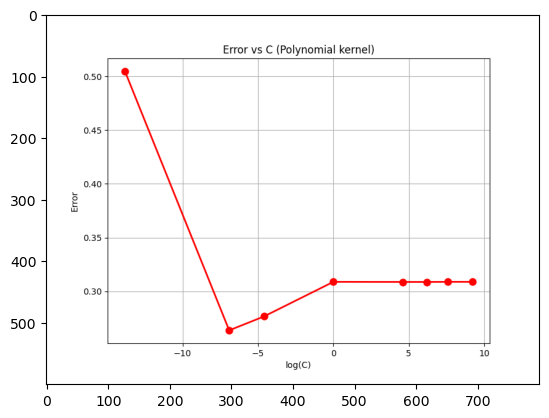

In [55]:
img = imread('plots/Err_pol_(0.5,5).png')
plt.imshow(img)

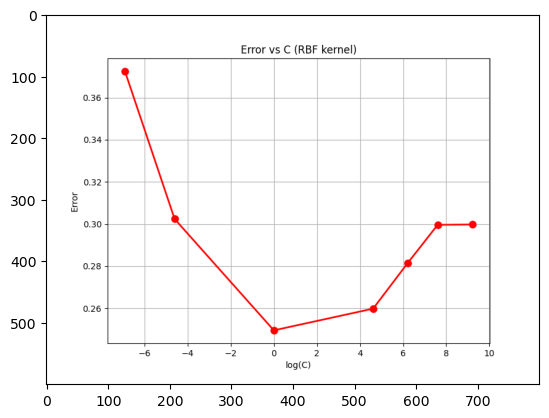

In [58]:
img = imread('plots/Err_rbf_(0.1).png')
plt.imshow(img)

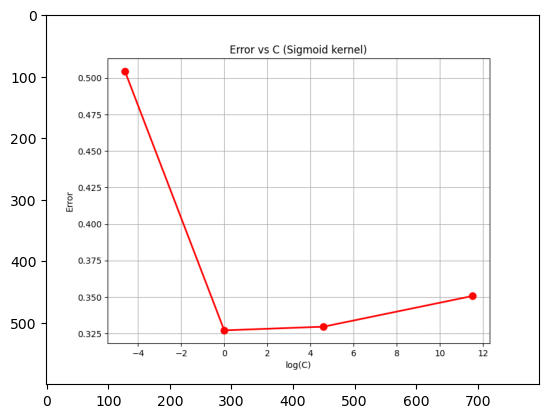

In [60]:
img = imread('plots/Err_sig_(0.001,0.001).png')
plt.imshow(img)

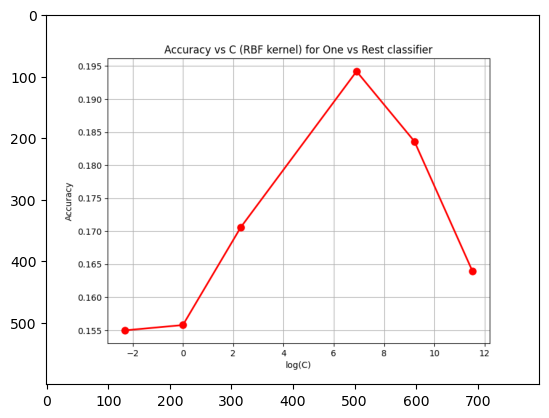

In [59]:
img = imread('plots/Err_rbf_(10)_ovr.png')
plt.imshow(img)

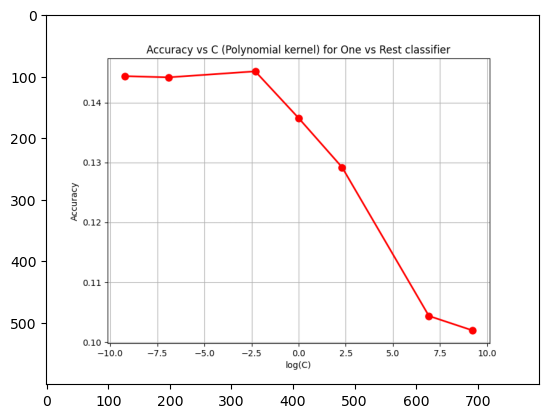

In [68]:
img = imread('plots/Err_poly_(1,10)_ovr.png')
plt.imshow(img)

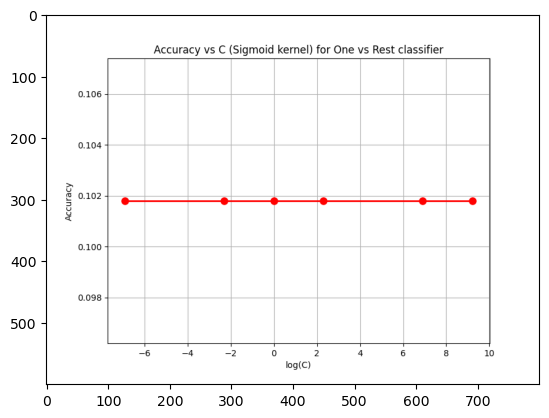

In [61]:
img = imread('plots/Err_sig_(0.001,0.001)_ovr.png')
plt.imshow(img)